In [1]:
import pandas as pd
import numpy as np
import os
import sys
from collections import Counter
import gget
import scipy
import scanpy as sc
from kneed import KneeLocator

from Bio import SeqIO
from Bio.KEGG import REST
from Bio.KEGG.KGML import KGML_parser

import matplotlib.pyplot as plt
import matplotlib.patheffects as pe
from mpl_toolkits.axes_grid1 import make_axes_locatable
import seaborn as sns

"""WARNING: disabling future warnings"""
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

sys.path.append("../")
import utils as ut

In [2]:
# fpath = "/nfs/turbo/umms-indikar/shared/projects/HSC/data/single-cell/nov2023_run1/scanpy/anndata.h5ad"
# fpath = "/nfs/turbo/umms-indikar/shared/projects/HSC/data/single-cell/nov2023_run2/scanpy/anndata.h5ad"
# fpath = "/scratch/indikar_root/indikar1/cstansbu/all_scHSC/scanpy/anndata.h5ad"
# fpath = "/scratch/indikar_root/indikar1/cstansbu/all_scHSC_run3/scanpy/anndata.h5ad"
# fpath = "/scratch/indikar_root/indikar1/cstansbu/all_scHSC_run4/scanpy/anndata.h5ad"
fpath = "/scratch/indikar_root/indikar1/cstansbu/all_HSC/scanpy/anndata.h5ad"


adata = sc.read(fpath, cache=False)
adata.layers["counts"] = adata.X.copy()
adata

AnnData object with n_obs × n_vars = 8632 × 19393
    obs: 'n_genes'
    var: 'gene_name', 'Chromosome', 'Start', 'End', 'Strand'
    layers: 'counts'

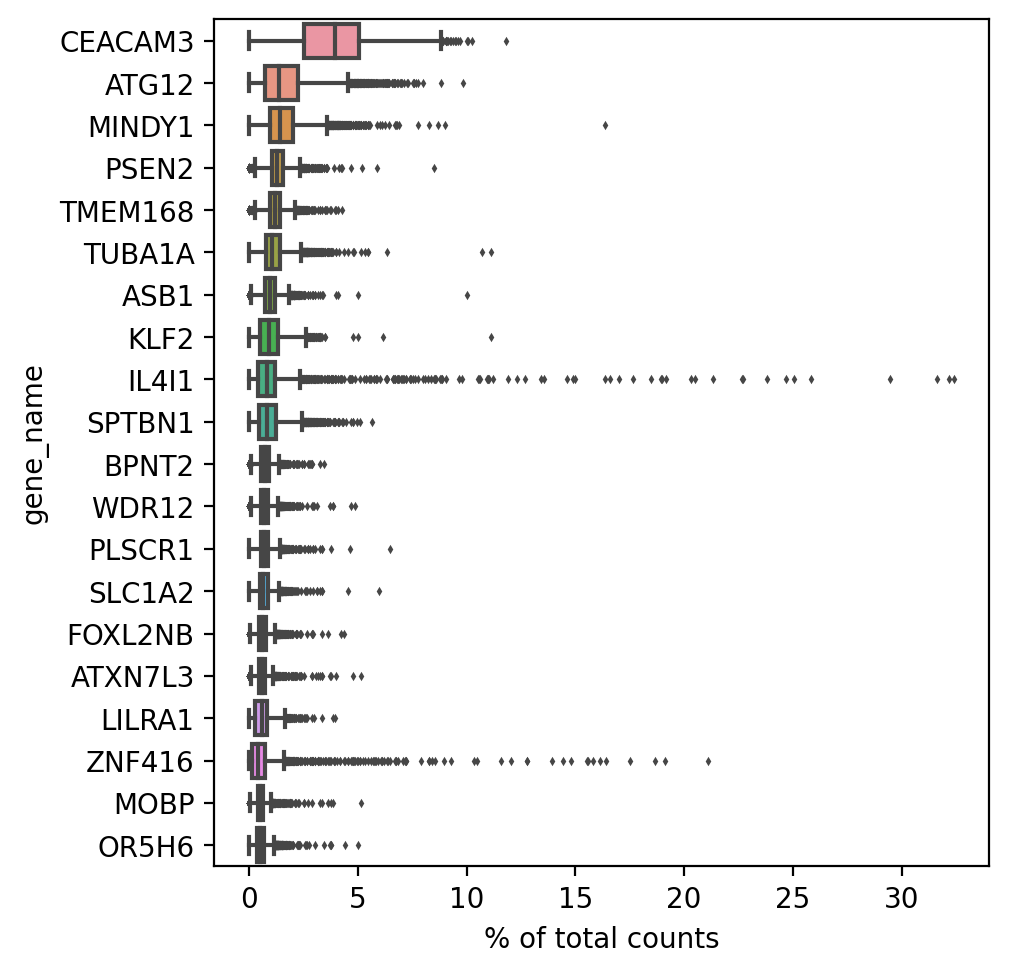

In [3]:
plt.rcParams['figure.dpi'] = 200
plt.rcParams['figure.figsize'] = 4, 4
sc.pl.highest_expr_genes(adata, n_top=20, gene_symbols='gene_name')

In [4]:
sc.pp.filter_cells(adata, min_genes=200)
sc.pp.filter_genes(adata, min_cells=3)

adata

AnnData object with n_obs × n_vars = 8475 × 14753
    obs: 'n_genes'
    var: 'gene_name', 'Chromosome', 'Start', 'End', 'Strand', 'n_cells'
    layers: 'counts'

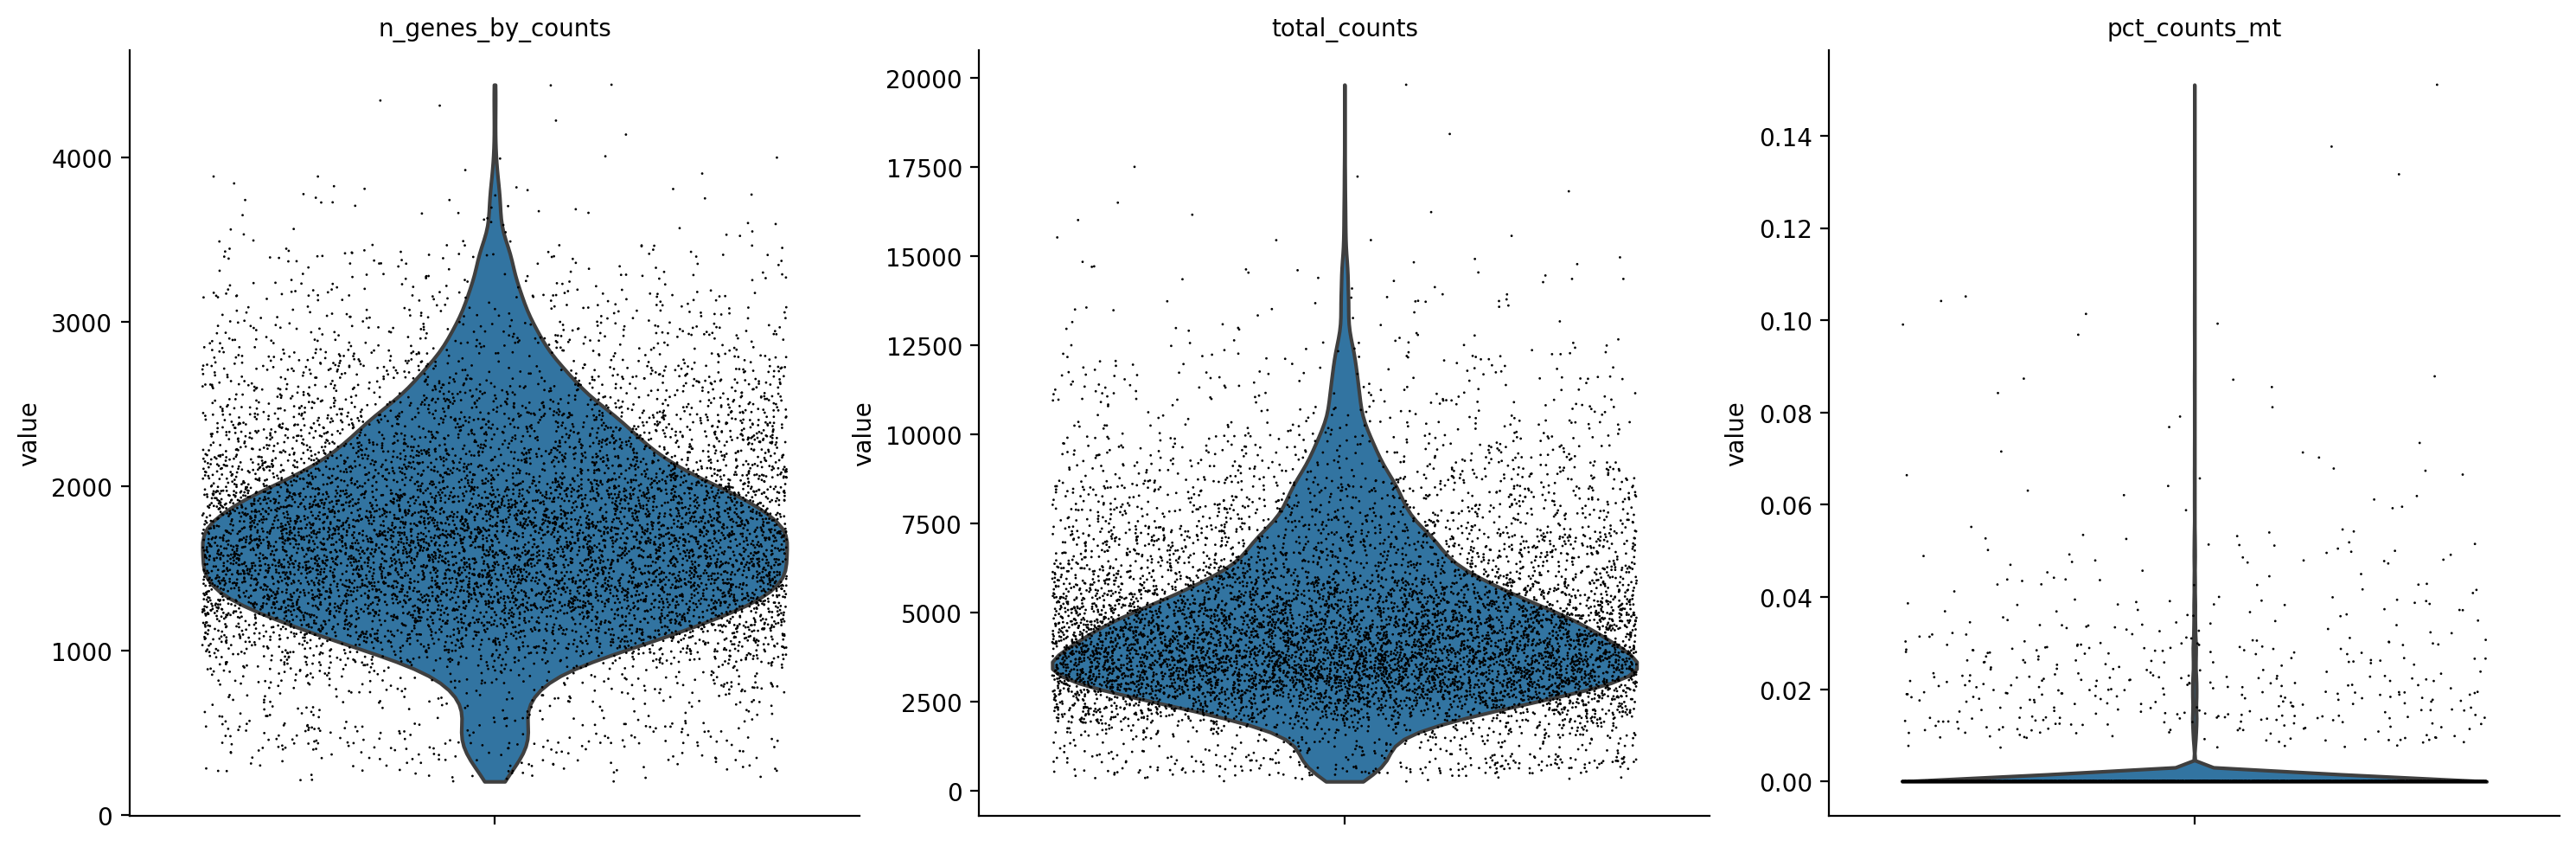

In [5]:
adata.var['mt'] = adata.var['gene_name'].str.startswith('MT-')  # annotate the group of mitochondrial genes as 'mt'
sc.pp.calculate_qc_metrics(adata, 
                           qc_vars=['mt'], 
                           percent_top=None,
                           log1p=False, 
                           inplace=True)

"""
A violin plot of some of the computed quality measures:

 - the number of genes expressed in the count matrix
 - the total counts per cell
 - the percentage of counts in mitochondrial genes
"""
plt.rcParams['figure.dpi'] = 200
plt.rcParams['figure.figsize'] = 3, 2.5
sc.pl.violin(adata, 
             ['n_genes_by_counts', 'total_counts', 'pct_counts_mt'],
             jitter=0.4, 
             multi_panel=True)

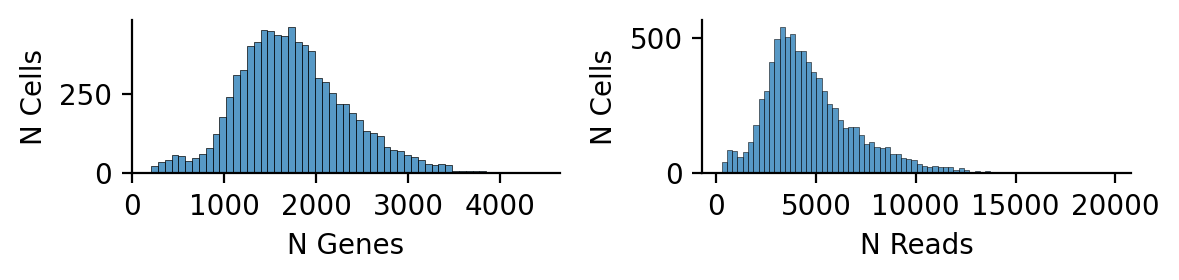

In [6]:
plt.rcParams['figure.dpi'] = 200
plt.rcParams['figure.figsize'] = 6, 1.5

fig, axs = plt.subplots(1, 2)

sns.histplot(data=adata.obs,
             x='n_genes_by_counts',
             ax=axs[0])

axs[0].set_ylabel('N Cells')
axs[0].set_xlabel('N Genes')

sns.histplot(data=adata.obs,
             x='total_counts',
             ax=axs[1])

axs[1].set_ylabel('N Cells')
axs[1].set_xlabel('N Reads')

sns.despine()
plt.tight_layout()

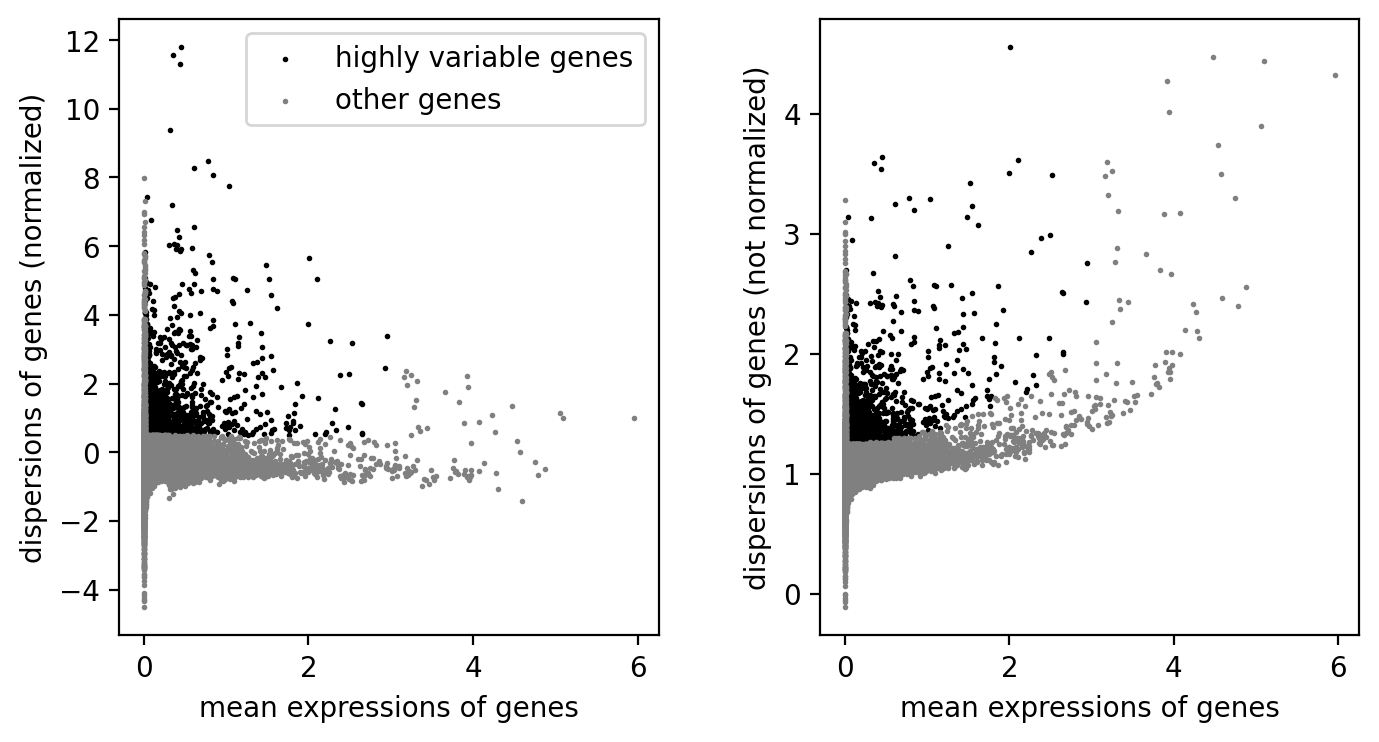

In [7]:
# preprocess
sc.pp.normalize_total(adata, target_sum=1e4)
sc.pp.log1p(adata)
sc.pp.highly_variable_genes(adata, min_mean=0.0125, max_mean=3, min_disp=0.5)

plt.rcParams['figure.dpi'] = 200
plt.rcParams['figure.figsize'] = 4, 4
sc.pl.highly_variable_genes(adata)

In [8]:
""" 
run3: 693.524794388002
"""
adata.obs['n_genes'].mean()

1744.6743362831858

In [9]:
""" 
run3: 1297.1390904692792
"""
adata.obs['total_counts'].mean()

4773.466312684366

In [10]:
# break

# Low dimensional embedding (PCA/UMAP)

# PCA

In [11]:
def get_hard_threshold(adata, plot=True):
    """A function to get the optimal hard threshold of a data matrix.
    Used to guide the choice of principal components """

    # OHT METHOD
    eigs = adata.uns['pca']['variance']
    tau = 2.858 * np.median(eigs)
    index = np.argwhere(eigs >= tau)
    oht = np.max(index) 

    # KNEED METHOD
    kneedle = KneeLocator(list(range(len(eigs))), 
                          eigs, 
                          S=1.0, 
                          curve="convex", 
                          direction="decreasing")
    knee = kneedle.knee
    print(f"{oht=} {knee=}")

    if plot:
        plt.plot(eigs, 
                 marker=".", 
                 c='k')
        plt.yscale('log')
        plt.ylabel(r"Magnitude")
        plt.xlabel("Eigenvalue")
        plt.title("Eigenvalues of Covariance Matrix")
        plt.axvline(x=oht, c='r', label=f'OHT ({oht})')
        plt.axvline(x=knee, c='b', label=f'Knee ({knee})')
        plt.legend()
        sns.despine()

False    12253
True      2500
Name: highly_variable, dtype: int64



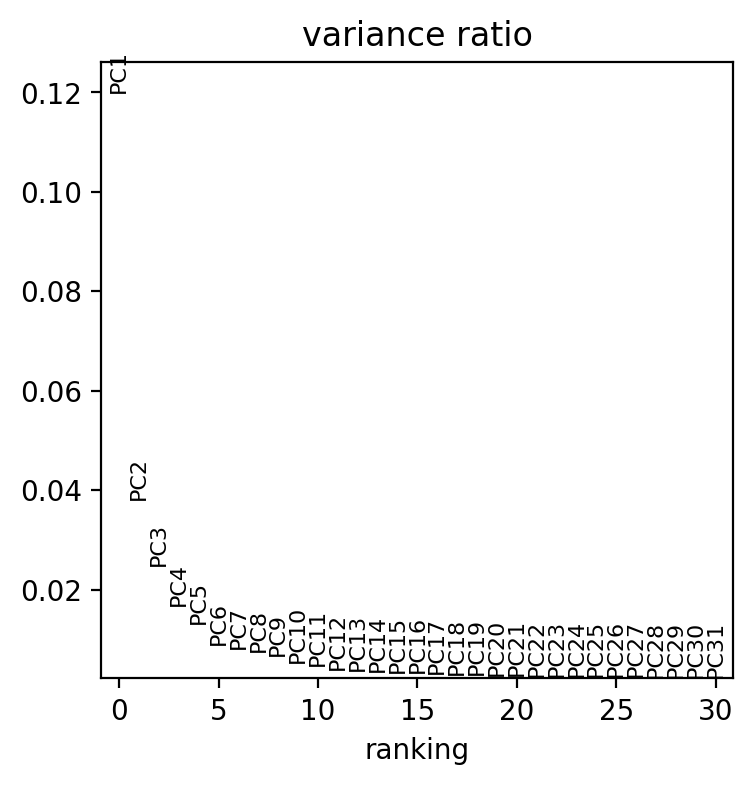

n_pca=2499 explained_variance=1.0000
oht=698 knee=22


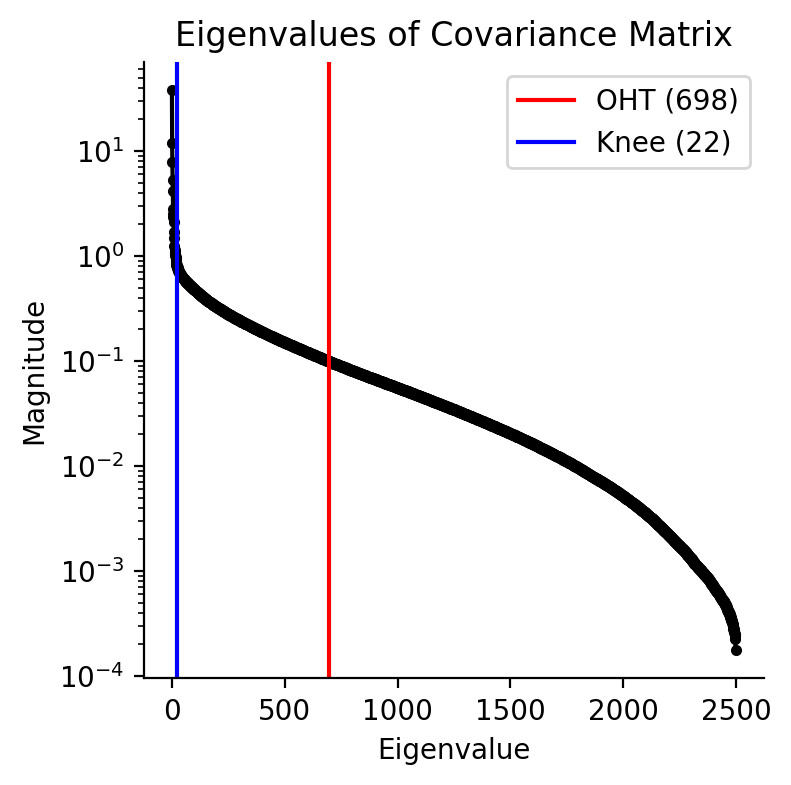

In [12]:
n_genes = 2500
n_pca = n_genes - 1  # full rank decomposition

sc.pp.highly_variable_genes(adata, n_top_genes=n_genes)

print(adata.var['highly_variable'].value_counts())
print()

# recompute the PCA using just the neurons
sc.tl.pca(adata, 
          n_comps=n_pca, 
          use_highly_variable=True)

# plot PCA results
sc.pl.pca_variance_ratio(adata)

# print the total explained variance
explained_variance = adata.uns['pca']['variance_ratio'].sum()

print(f"{n_pca=} {explained_variance=:0.4f}")

get_hard_threshold(adata)

# neighbors and clustering

In [13]:
n_pca = 25 # from above 
n_neighbors = 10
resolution = 0.1
key = f"clusters"

explained_variance = adata.uns['pca']['variance_ratio'].cumsum()[n_pca-1]
print(f"{n_pca=} {explained_variance=:.4f}")

# establish the nieghborhood
sc.pp.neighbors(adata, n_neighbors=n_neighbors, n_pcs=n_pca,)

# perform clustering
sc.tl.leiden(adata, 
             resolution=resolution,
             key_added=key)

adata.obs['cluster_name'] = adata.obs['clusters'].astype(int).apply(lambda x: f"C{x+1}")
adata.obs['cluster_name'].value_counts()

n_pca=25 explained_variance=0.2961


2024-01-11 14:26:55.577934: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-01-11 14:26:55.710134: I tensorflow/core/util/util.cc:169] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-01-11 14:26:55.737412: E tensorflow/stream_executor/cuda/cuda_blas.cc:2981] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-01-11 14:26:56.528874: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; 

RuntimeError: module compiled against API version 0xf but this version of numpy is 0xe

C1    5559
C2    1442
C3     916
C4     558
Name: cluster_name, dtype: int64

# Umap ebedding

... storing 'cluster_name' as categorical


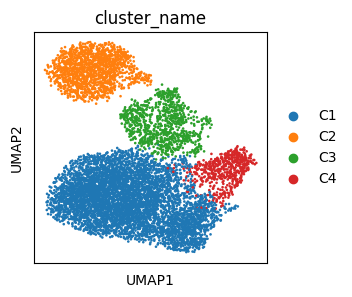

In [14]:
min_distance = 0.8
spread = 1
color_map = "nipy_spectral"

# build coarse-grained connectivity structures of complex manifolds 
sc.tl.paga(adata, groups='clusters')
sc.pl.paga(adata, plot=False)

# new embedding from the corse grained structures
sc.tl.umap(adata, 
           init_pos='paga',
           min_dist=min_distance, 
           spread=spread)

# build new obs columns
adata.obs['UMAP 1'] = adata.obsm['X_umap'][:, 0]
adata.obs['UMAP 2'] = adata.obsm['X_umap'][:, 1]

plt.rcParams['figure.dpi'] = 100
plt.rcParams['figure.figsize'] = 3, 3
sc.pl.umap(adata, color=['cluster_name'])

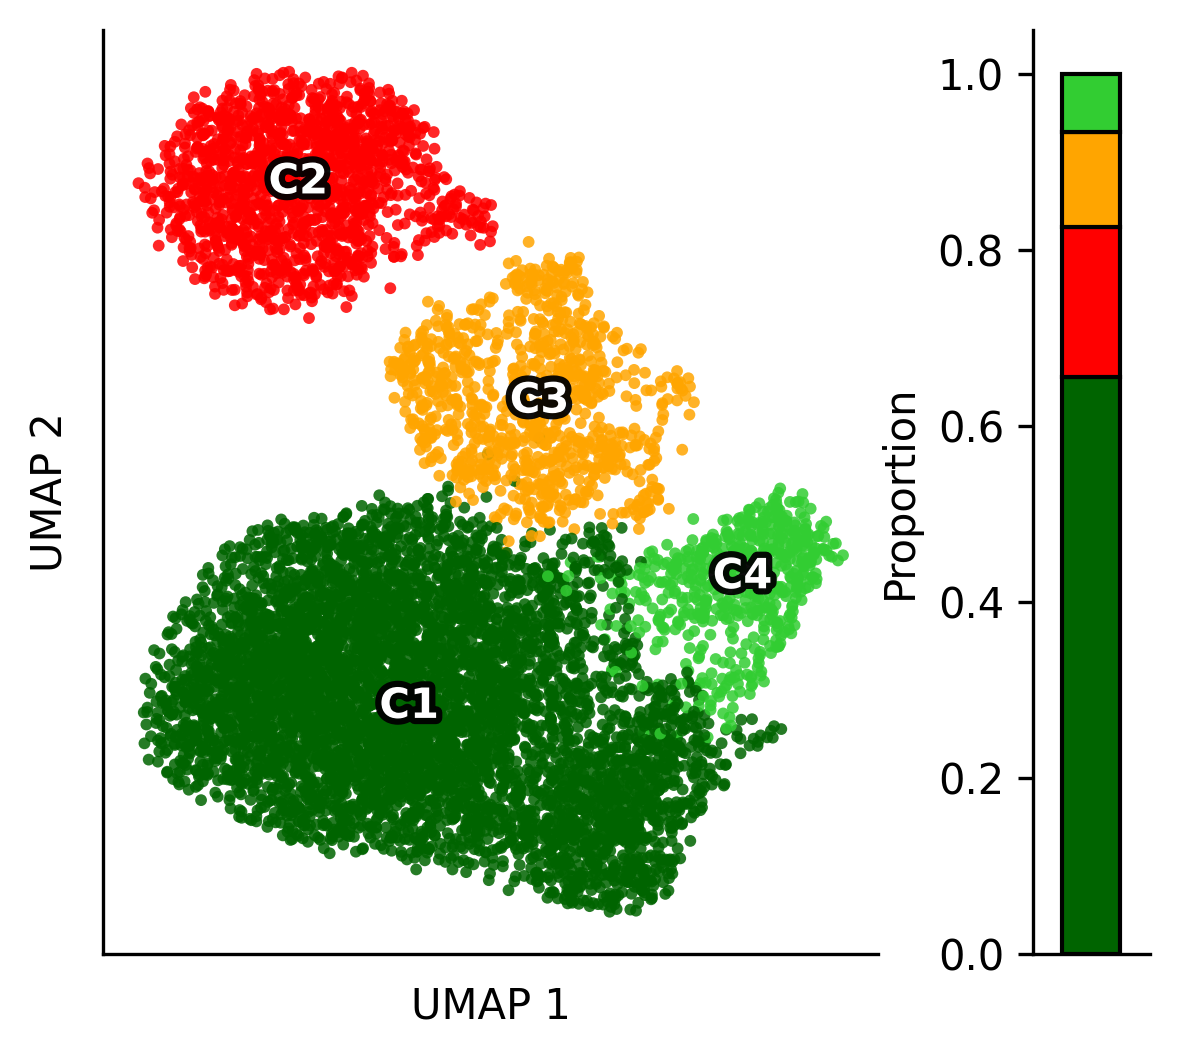

In [15]:
""" UMAP PLOT """
plt.rcParams['figure.dpi'] = 300
plt.rcParams['figure.figsize'] = 4.5, 4

colors = ['darkgreen', 'red', "orange", "limegreen"]


sns.scatterplot(data=adata.obs,
                x='UMAP 1',
                y='UMAP 2',
                hue='cluster_name',
                palette=colors,
                s=8,
                alpha=0.85,
                ec='none'
        )

sns.despine()
plt.xticks([])
plt.yticks([])

plt.xlabel("UMAP 1")
plt.ylabel("UMAP 2")

# label on data
ax = plt.gca()

def label_pos(labels, ax, color='w', fontsize=10,
              fw='bold', highlight="k", highlight_weight=3):
    """A function to add labels to each cluster """
    for idx, label_record in labels.iterrows():
        ax.text(
            label_record['UMAP 1'],
            label_record['UMAP 2'],
            label_record['label'],
            path_effects=[pe.withStroke(linewidth=highlight_weight, 
                                        foreground=highlight, 
                                        alpha=0.95,)],
            weight=fw,
            color=color,
            verticalalignment="center",
            horizontalalignment="center",
            fontsize=fontsize,
        )

all_pos = adata.obs.groupby('cluster_name')[['UMAP 1', 'UMAP 2']].median().reset_index()
all_pos.columns = ['label', 'UMAP 1', 'UMAP 2']

label_pos(all_pos, ax)

plt.gca().legend().remove()

divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="15%")

t = adata.obs['clusters'].value_counts(normalize=True).reset_index(drop=False).T
new_header = t.iloc[0] 
t = t[1:]
t.columns = ['C1', 'C2', 'C3', 'C4']
t.plot(kind='bar', 
       stacked=True,
       legend=False,
       color=colors,
       ax=cax,
       ec='k')

cax.set_xlabel("")
cax.set_xticks([])
cax.set_ylabel("Proportion")

sns.despine()

# Marker genes

In [16]:
def getGenes(pdf, cellType, ui_upper=None):
    genes = pdf[pdf['cell type'] == cellType]
    
    if not ui_upper is None:
        genes = genes[genes['ubiquitousness index'] < ui_upper]
    return genes['official gene symbol'].to_list()


pdfPath = "/nfs/turbo/umms-indikar/shared/projects/spatial_transcriptomics/data/panglaodb/pandb.tsv.gz"
pandDf = pd.read_csv(pdfPath, sep="\t")

fb = getGenes(pandDf, 'Fibroblasts')
hp = getGenes(pandDf, 'Hematopoietic stem cells')

print(f"FB genes: {len(fb)}")
print(f"HP genes: {len(hp)}")

print(Counter(fb + hp).most_common(5)) # there are three genes shared in both lists


marker_genes = {
    'Fibroblast' : adata.var[adata.var['gene_name'].isin(fb)].index,
    'HSC' : adata.var[adata.var['gene_name'].isin(hp)].index,
}

id2name = dict(zip(adata.var.index.values, adata.var['gene_name'].values))
name2id = dict(zip(adata.var['gene_name'].values, adata.var.index.values))

FB genes: 179
HP genes: 88
[('THY1', 2), ('CD44', 2), ('EGR1', 2), ('RUNX1', 2), ('IL1R1', 1)]


In [17]:
# make some observation columns
for k, v in marker_genes.items():
    print(k, v.shape)

    adata.obs[f"{k}_mean"] = adata[:, v].X.mean(axis=1).copy()
    adata.obs[f"{k}_max"] = adata[:, v].X.max(axis=1).copy()
    adata.obs[f"{k}_argmax"] = adata[:, v].X.argmax(axis=1).copy()
    adata.obs[f"{k}_highest_exp"] = adata.obs[f"{k}_argmax"].apply(lambda x : id2name[v[x]])

adata.obs.head()

Fibroblast (135,)
HSC (71,)


n_genes  n_genes_by_counts  total_counts  total_counts_mt  \
cell_id                                                                       
AAACCCAAGGTTACCT     1771               1771          4345                0   
AAACCCAAGTTGAAGT     1727               1727          3572                0   
AAACCCAAGTTGTCGT     1261               1261          2841                0   
AAACCCACAGAAGCGT     1210               1210          2298                0   
AAACCCACAGGAGGTT     2796               2796          9515                0   

                  pct_counts_mt clusters cluster_name    UMAP 1     UMAP 2  \
cell_id                                                                      
AAACCCAAGGTTACCT            0.0        0           C1  4.961397  -2.835662   
AAACCCAAGTTGAAGT            0.0        0           C1  0.812343  -0.706095   
AAACCCAAGTTGTCGT            0.0        1           C2  3.897857  11.839667   
AAACCCACAGAAGCGT            0.0        1           C2 -0.392290  13.762138   
AAACCCACAGGAGGTT            0.0        0           C1  1.551165  -3.834481   

                  Fibroblast_mean  Fibroblast_max  Fibroblast_argmax  \
cell_id                                                                
AAACCCAAGGTTACCT         0.222723        4.145360                128   
AAACCCAAGTTGAAGT         0.249179        4.301201                 35   
AAACCCAAGTTGTCGT         0.144685        2.713340                128   
AAACCCACAGAAGCGT         0.125907        3.578308                128   
AAACCCACAGGAGGTT         0.274624        4.893521                128   

                 Fibroblast_highest_exp  HSC_mean   HSC_max  HSC_argmax  \
cell_id                                                                   
AAACCCAAGGTTACCT                   KLF2  0.166299  1.723301           5   
AAACCCAAGTTGAAGT                  FSTL1  0.184761  1.886934          38   
AAACCCAAGTTGTCGT                   KLF2  0.106231  1.508487          17   
AAACCCACAGAAGCGT                   KLF2  0.131726  2.642966          52   
AAACCCACAGGAGGTT                   KLF2  0.117115  1.132029          29   

                 HSC_highest_exp  
cell_id                           
AAACCCAAGGTTACCT           PTPRC  
AAACCCAAGTTGAAGT             TEK  
AAACCCAAGTTGTCGT            FGD5  
AAACCCACAGAAGCGT           MGST1  
AAACCCACAGGAGGTT             APC

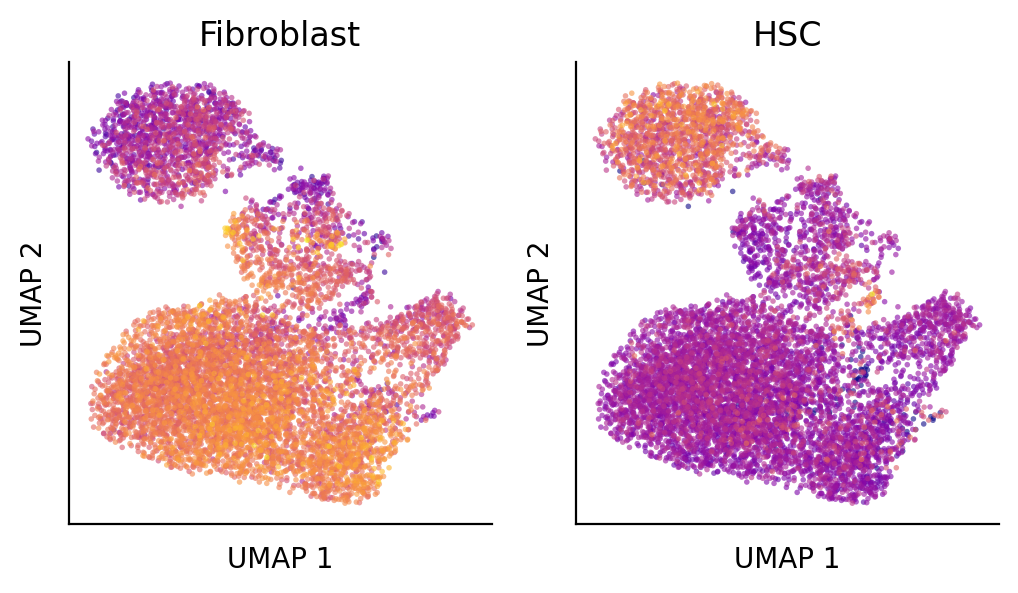

In [18]:
plt.rcParams['figure.dpi'] = 200
plt.rcParams['figure.figsize'] = 6, 3

pdf = adata.obs.copy()
fig, axs = plt.subplots(1, 2)

cmap = 'plasma'
size = 4
alpha = 0.6

# sort order
order1 = np.argsort(pdf['Fibroblast_max'])
order2 = np.argsort(pdf['HSC_max'])


sns.scatterplot(data=pdf.iloc[order1], 
                x='UMAP 1',
                y='UMAP 2',
                hue='Fibroblast_max',
                palette=cmap,
                alpha=alpha,
                ax=axs[0],
                s=size,
                ec='none')

axs[0].set_yticks([])
axs[0].set_xticks([])
axs[0].legend().remove()
axs[0].set_title('Fibroblast')

sns.scatterplot(data=pdf.iloc[order2], 
                x='UMAP 1',
                y='UMAP 2',
                hue='HSC_max',
                palette=cmap,
                alpha=alpha,
                ax=axs[1],
                s=size,
                ec='none')

axs[1].set_yticks([])
axs[1].legend().remove()
axs[1].set_xticks([])
axs[1].set_title('HSC')

# # label clusters
# label_pos(all_pos, axs[0])
# label_pos(all_pos, axs[1])

sns.despine()

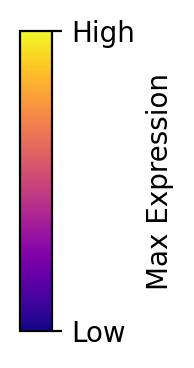

In [19]:
ut.makeColorbar('plasma', 0.2, 2.5, 'Max Expression', 'vertical', ['Low', 'High'])

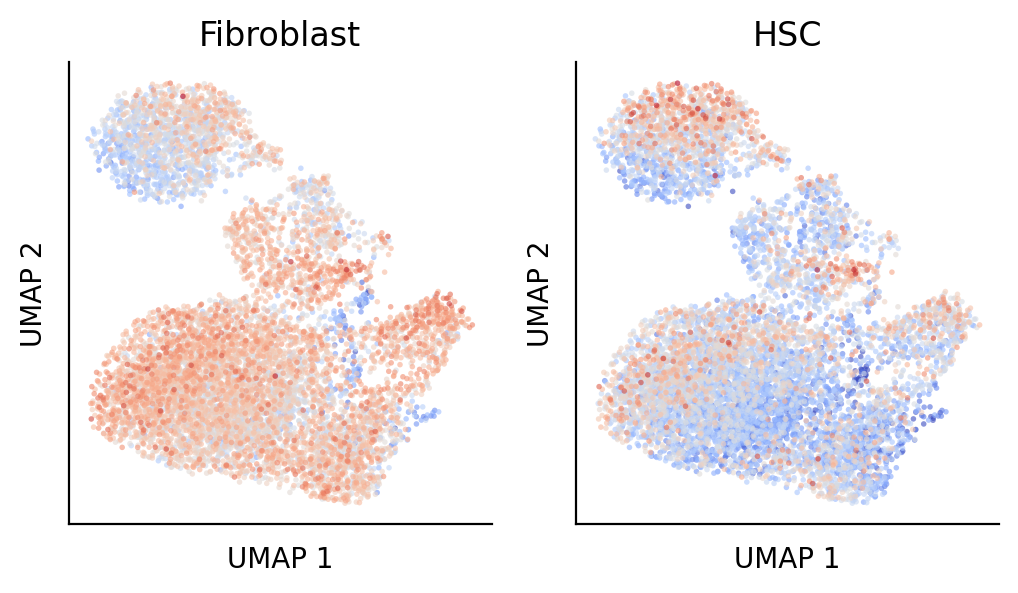

In [20]:
plt.rcParams['figure.dpi'] = 200
plt.rcParams['figure.figsize'] = 6, 3

pdf = adata.obs.copy()
fig, axs = plt.subplots(1, 2)

cmap = 'coolwarm'
size = 4
alpha = 0.6

# sort order
order1 = np.argsort(pdf['Fibroblast_mean'])
order2 = np.argsort(pdf['HSC_mean'])


sns.scatterplot(data=pdf.iloc[order1], 
                x='UMAP 1',
                y='UMAP 2',
                hue='Fibroblast_mean',
                palette=cmap,
                alpha=alpha,
                ax=axs[0],
                s=size,
                ec='none')

axs[0].set_yticks([])
axs[0].set_xticks([])
axs[0].legend().remove()
axs[0].set_title('Fibroblast')

sns.scatterplot(data=pdf.iloc[order2], 
                x='UMAP 1',
                y='UMAP 2',
                hue='HSC_mean',
                palette=cmap,
                alpha=alpha,
                ax=axs[1],
                s=size,
                ec='none')

axs[1].set_yticks([])
axs[1].legend().remove()
axs[1].set_xticks([])
axs[1].set_title('HSC')

sns.despine()

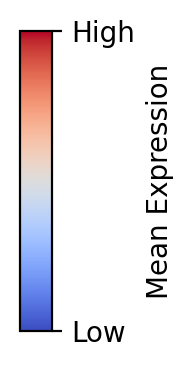

In [21]:
ut.makeColorbar(cmap, 0.2, 2.5, 'Mean Expression', 'vertical', ['Low', 'High'])

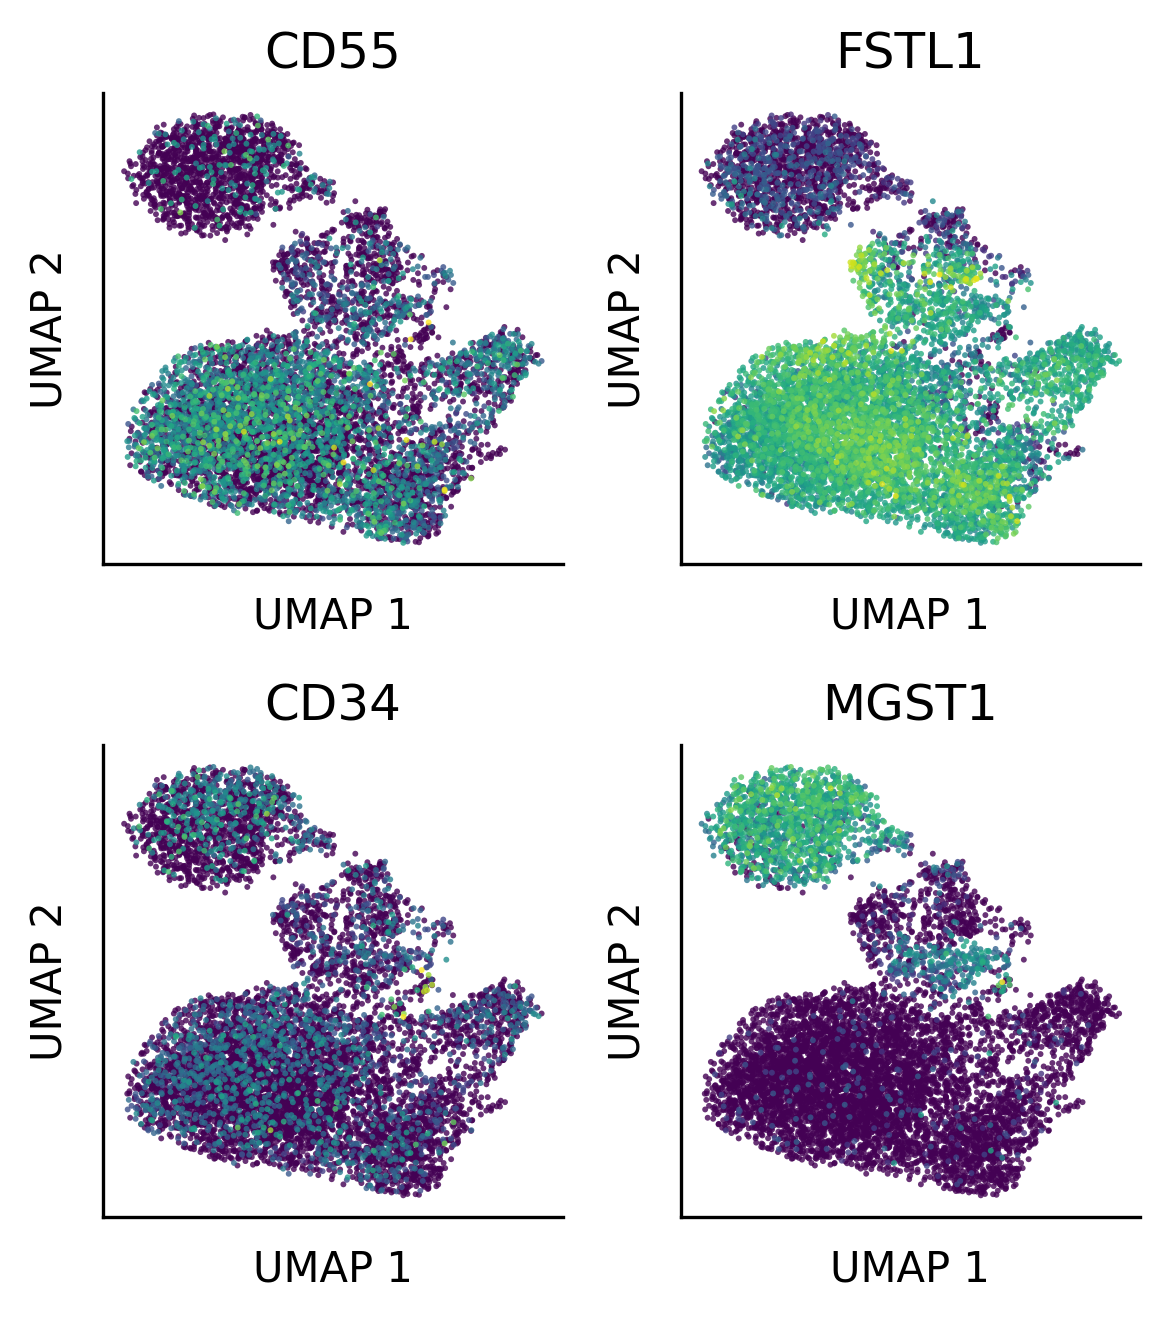

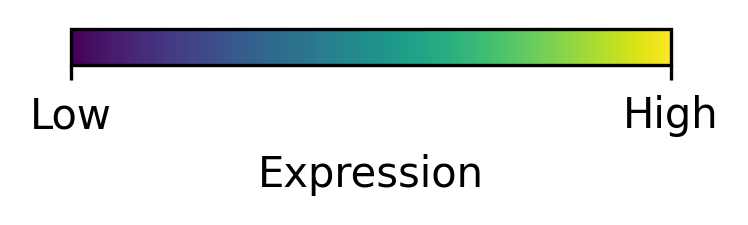

In [22]:
def plot_genes(adata, gene_list, cmap='viridis', 
               subplots=(2, 2), figsize=(4, 4.5),
               cbar=True, cbar_type='horizontal',
               cbar_label='Expression',
               cbar_markers=['Low', 'High'],
               label_clusters=False, 
               cluster_labels=all_pos,
               **label_kwargs):
    """A function to plot gene expression """
    

    plt.rcParams['figure.dpi'] = 300
    plt.rcParams['figure.figsize'] = figsize
    fig, axs = plt.subplots(subplots[0], subplots[1])
    axs = axs.ravel()

    for i, g in enumerate(gene_list):
        gene_name = adata.var[adata.var['gene_name'] == g].index[0]
        v = adata[:, [gene_name]].X.copy()
        gdf = adata.obs.copy()
        gdf['exp'] = np.ravel(v)
    
        order = np.argsort(gdf['exp'])
    
        axs[i].scatter(gdf['UMAP 1'][order], 
                       gdf['UMAP 2'][order],
                       c=gdf['exp'][order],
                       cmap=cmap,
                       s=2,
                       alpha=0.8,
                       ec='none')
        
        axs[i].set_title(g)
    
        axs[i].set_xticks([])
        axs[i].set_yticks([])
        axs[i].set_xlabel("UMAP 1")
        axs[i].set_ylabel("UMAP 2")
        
        if  label_clusters:
            label_pos(all_pos, axs[i], **label_kwargs)

    sns.despine()
    plt.tight_layout()

    if cbar:
       ut.makeColorbar(cmap, 
                       2.5, 0.2, 
                       cbar_label, 
                       cbar_type, 
                       cbar_markers)

gene_list = [
    'CD55',
    'FSTL1',
    'CD34', 
    'MGST1',     
] 

plot_genes(adata, 
           gene_list, 
           cmap='viridis', 
           subplots=(2, 3), 
           figsize=(4, 4.5),
           label_clusters=False,
           fontsize=6)

['CD55', 'FSTL1', 'CD34', 'MGST1']


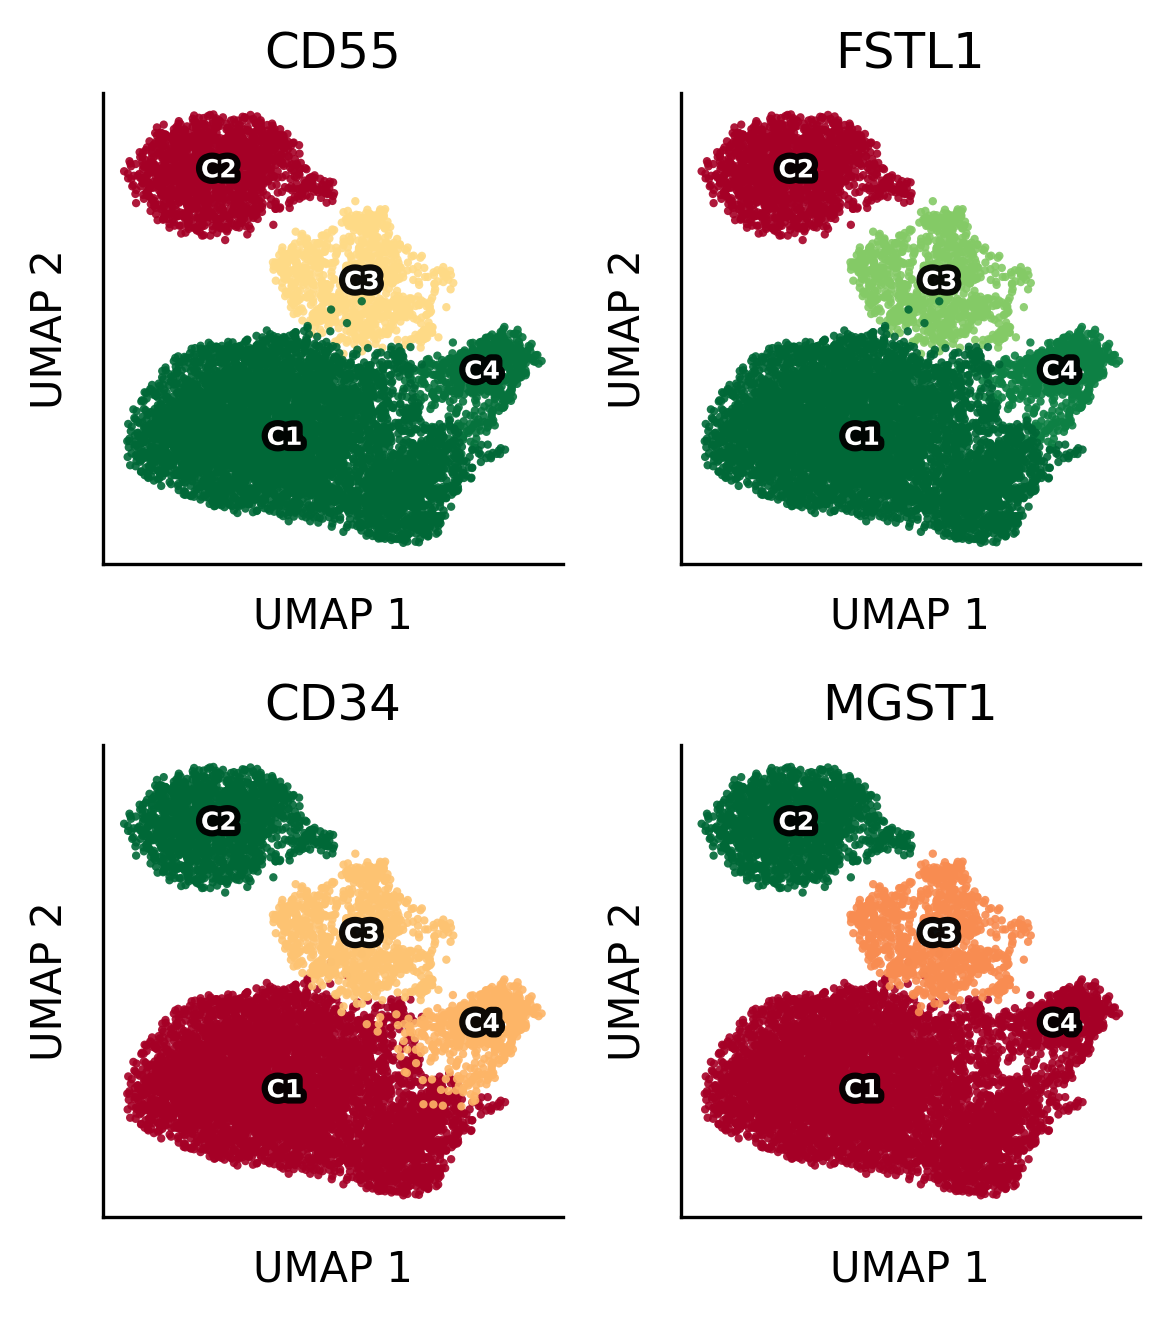

In [23]:
def get_summary(cdf, agg_funcs=['mean', 'std','median', 'count',]):
    """A function to get summaries for a query"""
    # get non-zero counts
    nonzero = pd.DataFrame(cdf.apply(np.count_nonzero, axis=0), 
                       columns=['nonzero'])
    
    # get aggregate stats
    cdf = cdf.agg(agg_funcs, axis=0).T
    
    cdf = pd.merge(cdf, 
               nonzero, 
               how='left', 
               left_index=True, 
               right_index=True)
    cdf['pct_expressing'] = cdf['nonzero'] / cdf['count']
    return cdf


def get_gene_ids(adata, gene_list):
    """A function to return gene names and gene ids"""
    res = []
    genes = adata.var.copy()

    for gene in gene_list:
        if gene in genes['gene_name'].to_list():
            row = {
                'gene_name' : genes.loc[genes['gene_name'] == gene]['gene_name'].values[0],
                'gene_id' : genes.loc[genes['gene_name'] == gene].index.values[0]
            }
            res.append(row)
    return pd.DataFrame(res)
    
    
def plot_cluster_average_expression(adata, 
                                    gene_list, 
                                    all_pos,
                                    cmap='RdYlGn',
                                    plot_shape=(3, 3), 
                                    fig_shape=(5, 5),
                                    axis_labels=True,
                                    scale_bars=False,
                                    label_clusters=False,
                                    **label_kwargs):

    genes = get_gene_ids(adata, gene_list)

    res = []                                        
    for cluster, group in adata.obs.groupby('cluster_name'):
        cell_idx = group.index
        cdf = adata[cell_idx, genes['gene_id'].to_list()].to_df()
        cdf.columns = genes['gene_name'].to_list()
    
        cdf = get_summary(cdf, agg_funcs=['mean', 'count'])
        cdf['cluster'] = cluster
        res.append(cdf)
    res = pd.concat(res)
    res = res.reset_index(drop=False)                                      
    res = pd.pivot_table(res, 
                         index='cluster',
                         columns='index',
                         values='mean',
                        )                                  
   
    pdx = adata.obs.copy()    
    pdx = pd.merge(pdx, res,
                   how='left',
                   left_on='cluster_name',
                   right_on='cluster')
                              
    plt.rcParams['figure.dpi'] = 300
    plt.rcParams['figure.figsize'] = fig_shape
    fig, axs = plt.subplots(plot_shape[0], plot_shape[1])
    axs = axs.ravel()

    for i, g in enumerate(gene_list):
        order = np.argsort(pdx[g])
        p = axs[i].scatter(pdx['UMAP 1'][order], 
                           pdx['UMAP 2'][order],
                           c=pdx[g][order],
                           s=4,
                           cmap=cmap,
                           alpha=0.9,
                           ec='none')

        if scale_bars:
             plt.colorbar(p, ax=axs[i], shrink=0.5)
        
        axs[i].set_title(g)
        axs[i].set_xticks([])
        axs[i].set_yticks([])
        axs[i].set_xlabel("UMAP 1")
        axs[i].set_ylabel("UMAP 2")

        if not axis_labels:
            axs[i].set_xlabel("")
            axs[i].set_ylabel("")
        
        if  label_clusters:
            label_pos(all_pos, axs[i], **label_kwargs)

    plt.tight_layout()
    sns.despine()

print(gene_list)
plot_cluster_average_expression(adata, 
                                gene_list,
                                all_pos,
                                label_clusters=True,
                                fontsize=6,
                                plot_shape=(2, 2), 
                                fig_shape=(4, 4.5))

# Fibroblast program

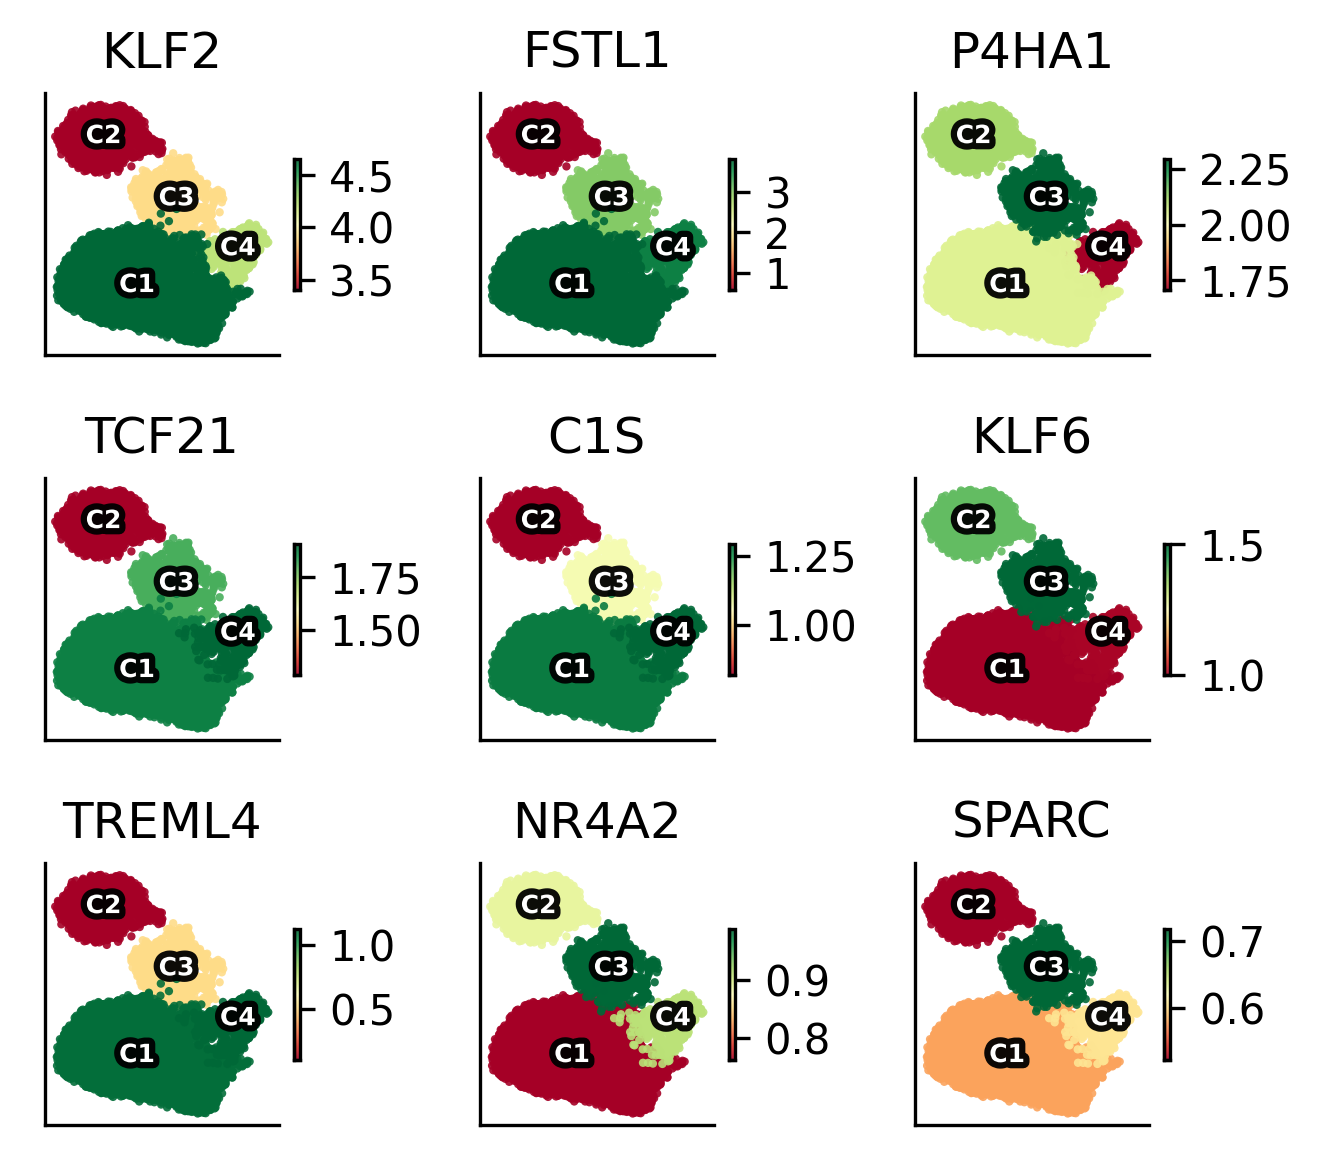

In [24]:
n_top_genes = 9

def get_top_genes(adata, gene_list, n_top_genes=10):
    """A function to order genes by their GLOBAL mean expression """
    overlap = adata.var[adata.var['gene_name'].isin(gene_list)]
    
    gene_ids = overlap.index.to_list()
    gene_names = overlap['gene_name'].to_list()
    expr = adata[:, gene_ids].to_df()
    expr.columns = gene_names

    means = expr.mean()
    means = means.sort_values(ascending=False)
    if not n_top_genes is None:
        top_genes = means.head(n_top_genes).index
    else:
        top_genes = means

    return top_genes

    
top_fb_exp = get_top_genes(adata, fb, n_top_genes)
plot_cluster_average_expression(adata, 
                                top_fb_exp,
                                all_pos,
                                label_clusters=True,
                                axis_labels=False,
                                scale_bars=True,
                                fontsize=6,
                                plot_shape=(3, 3), 
                                fig_shape=(4.5, 4))

# HSC Program

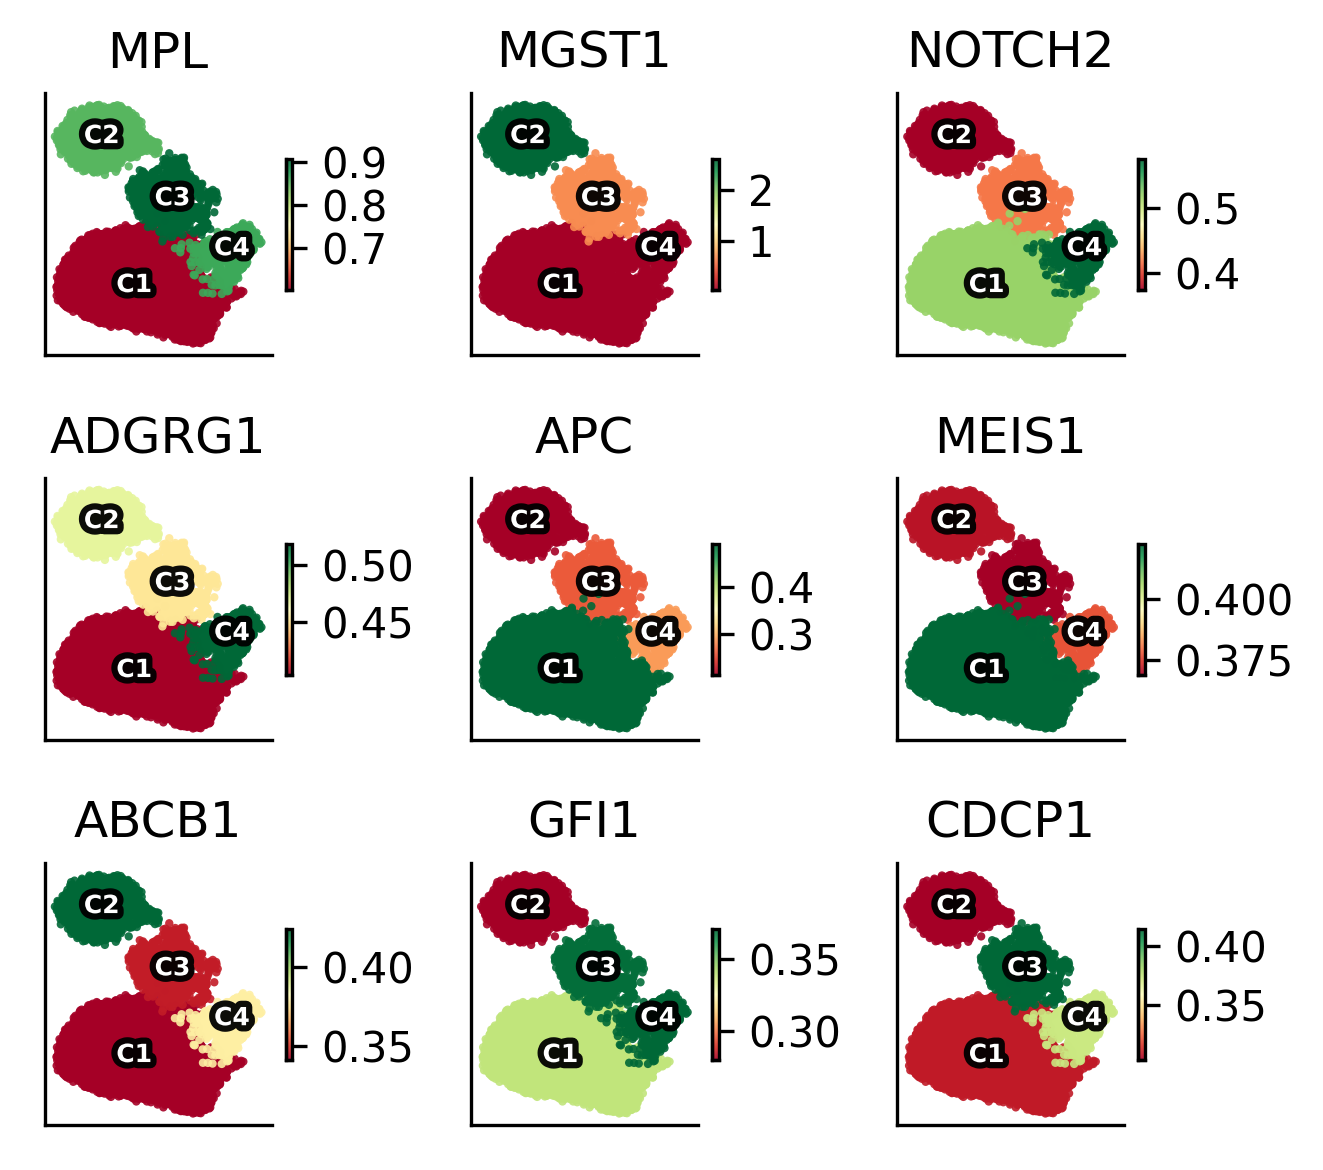

In [25]:
top_hp_exp = get_top_genes(adata, hp, n_top_genes)
top_hp_exp
plot_cluster_average_expression(adata, 
                                top_hp_exp,
                                all_pos,
                                label_clusters=True,
                                axis_labels=False,
                                scale_bars=True,
                                fontsize=6,
                                plot_shape=(3, 3), 
                                fig_shape=(4.5, 4))

# Differential expression

... storing 'Fibroblast_highest_exp' as categorical
... storing 'HSC_highest_exp' as categorical


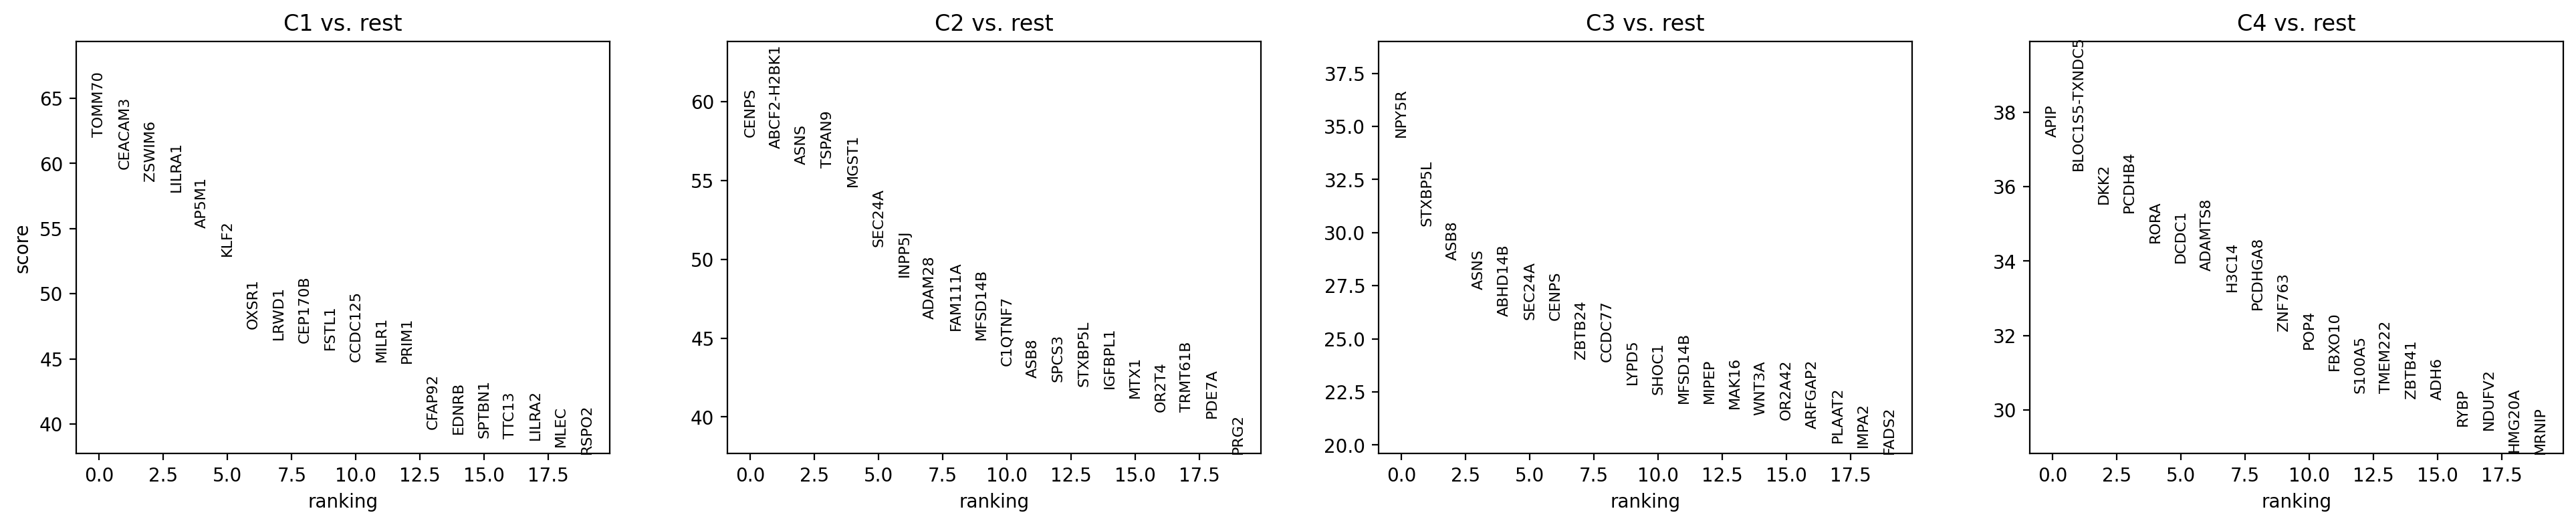

group            names     scores  logfoldchanges  pvals  pvals_adj  \
0    C1  ENSG00000154174  62.039959        3.283708    0.0        0.0   
1    C1  ENSG00000170956  59.577744        1.113002    0.0        0.0   
2    C1  ENSG00000130449  58.664860        2.992623    0.0        0.0   
3    C1  ENSG00000104974  57.837212        2.287771    0.0        0.0   
4    C1  ENSG00000053770  55.065548        2.705340    0.0        0.0   

  gene_name  
0    TOMM70  
1   CEACAM3  
2    ZSWIM6  
3    LILRA1  
4     AP5M1

In [26]:
sc.tl.rank_genes_groups(adata, 'cluster_name', method='wilcoxon')

plt.rcParams['figure.dpi'] = 200
plt.rcParams['figure.figsize'] = 6, 4

sc.pl.rank_genes_groups(adata, 
                        n_genes=20, 
                        sharey=False, 
                        gene_symbols='gene_name')

deg = sc.get.rank_genes_groups_df(adata, 
                                  gene_symbols='gene_name',
                                  group=None)

deg.head()

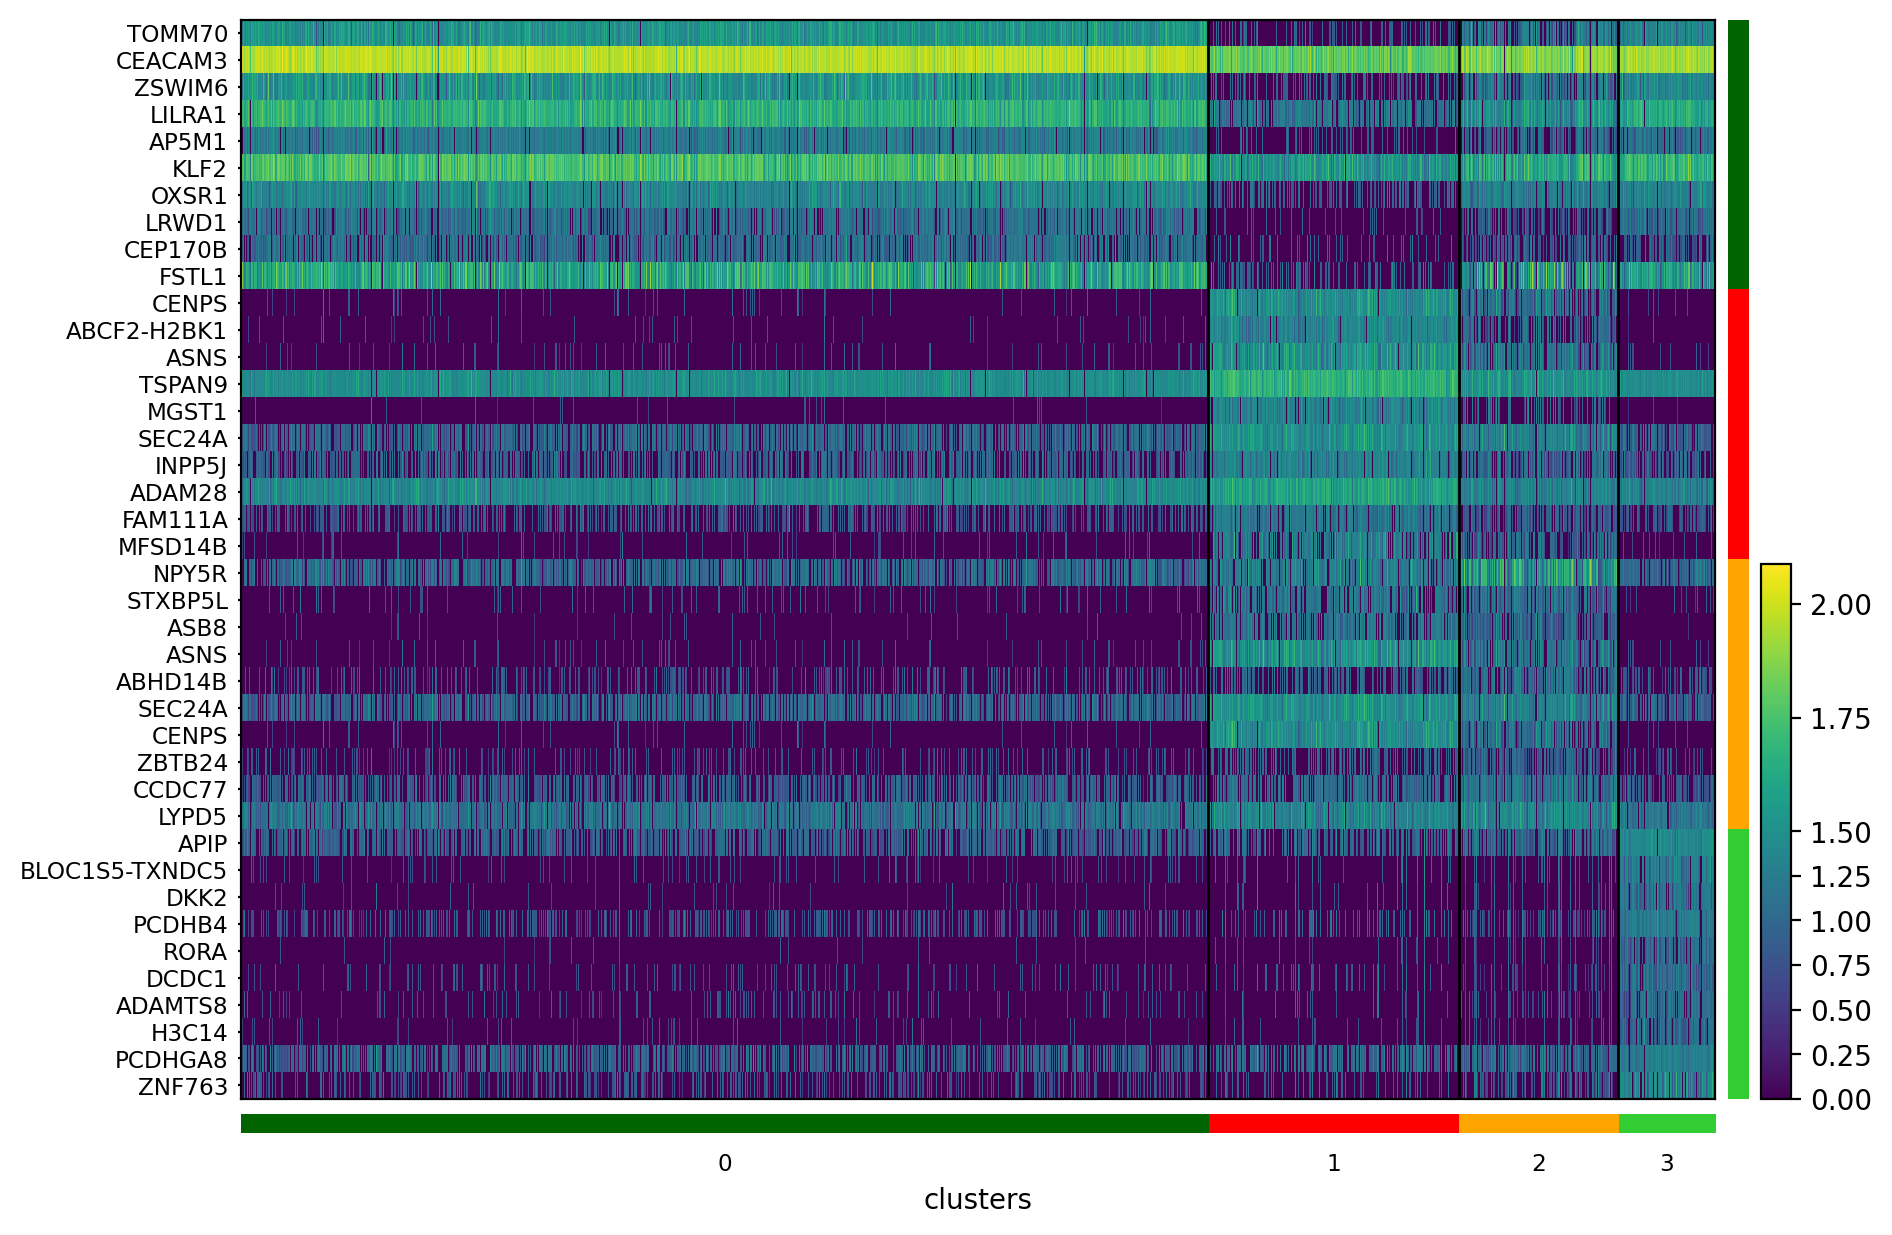

In [64]:
plt.rcParams['figure.dpi'] = 200
plt.rcParams['figure.figsize'] = 6, 6

sc.pl.rank_genes_groups_heatmap(adata, 
                                n_genes=10, 
                                use_raw=False, 
                                dendrogram=False,
                                log=True,
                                groupby='clusters',
                                swap_axes=True, 
                                show_gene_labels=True,
                                vcenter=1.5,
                                gene_symbols='gene_name',
                                cmap='viridis')

edf.shape=(9074, 7)


group            names     scores  logfoldchanges          pvals  \
515    C1  ENSG00000156232   5.440597        2.706271   5.310241e-08   
13     C1  ENSG00000114656  39.602554        2.615547   0.000000e+00   
132    C1  ENSG00000176422  14.797804        2.612562   1.513445e-49   
43     C1  ENSG00000069535  30.043840        2.494686  2.627668e-198   
423    C1  ENSG00000155897   6.366228        2.487562   1.937340e-10   

         pvals_adj gene_name  perc_expressing type  
515   5.615913e-07     WHAMM         0.064779   NA  
13    0.000000e+00    CFAP92         0.564366   NA  
132   7.043486e-48    SPRYD4         0.185251   NA  
43   4.455860e-196      MAOB         0.413333   NA  
423   2.461807e-09     ADCY8         0.080590   NA

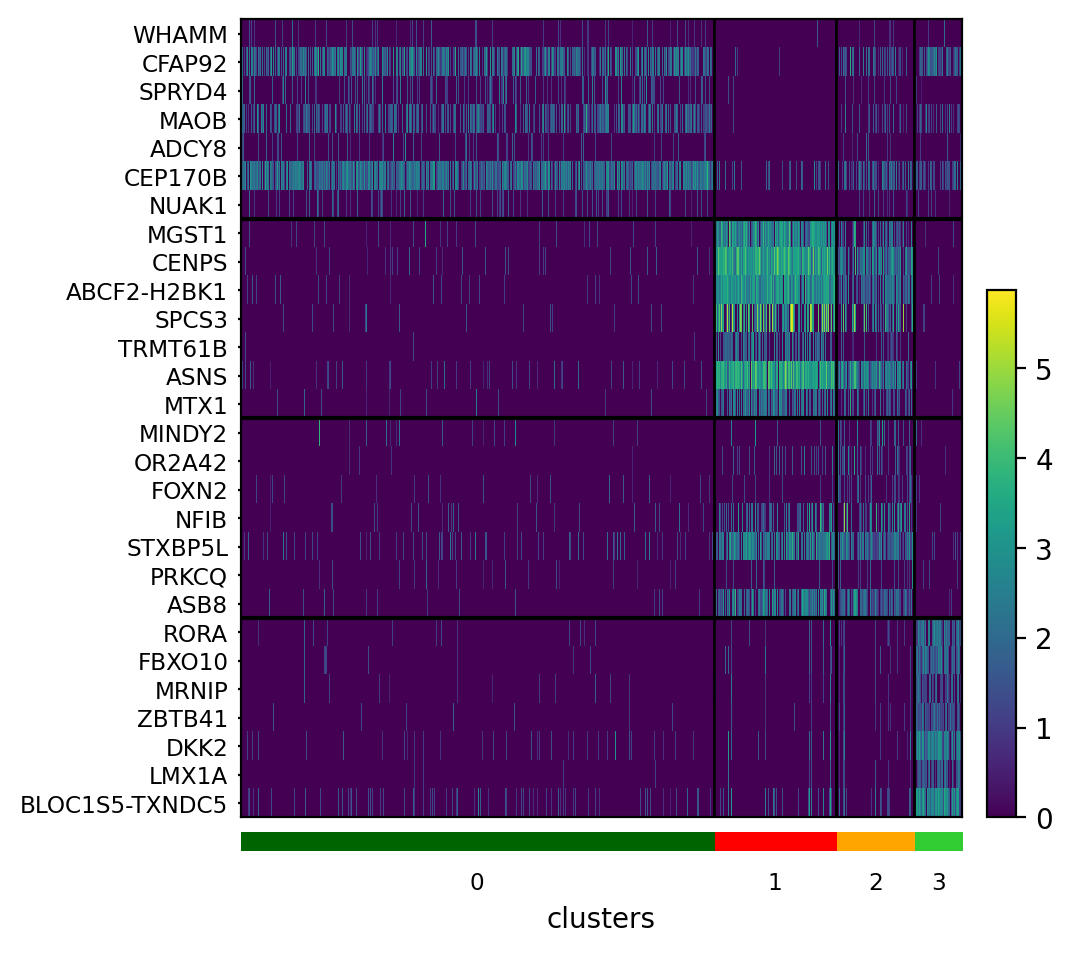

In [65]:
top = 7
alpha = 0.01
ubiquity_threshold = 0.05
ubiquity_threshold_upper = 0.75
edf = deg.copy()

# set the colors for the bars underneath (STUPID)
adata.uns['clusters_colors'] = colors 

edf = edf[(edf['pvals_adj'] < alpha)]

# unbiquity thresholding
print(f"{edf.shape=}")

genes = edf['names'].to_list()
perc_expressing = adata[:, genes].X.astype(bool).astype(int)
perc_expressing = perc_expressing.sum(axis=0)
edf['perc_expressing'] = perc_expressing / len(adata)
edf = edf[edf['perc_expressing'] > ubiquity_threshold]
edf = edf[edf['perc_expressing'] < ubiquity_threshold_upper]

# sorting and subsetting the top genes
edf = edf.sort_values(by=['group', 'logfoldchanges'], ascending=[True, False])
edf = edf.groupby('group').head(top)

edf['type'] = np.where(edf['gene_name'].isin(fb), 'Fibroblast', 'NA')
edf['type'] = np.where(edf['gene_name'].isin(hp), 'HSC', edf['type'])

var_names = edf['gene_name'].to_list()

plt.rcParams['figure.dpi'] = 200
plt.rcParams['figure.figsize'] = 6, 6

ax = sc.pl.heatmap(adata,
              groupby='clusters',
              figsize=(5, 5.5),
              use_raw=False, 
              var_names=var_names,
              swap_axes=True, 
              show=False,
              standard_scale=True,
              show_gene_labels=True,
              gene_symbols='gene_name',
              cmap='viridis')

ax['heatmap_ax'].axhline(y=top-0.5, c='k')
ax['heatmap_ax'].axhline(y=(2*top)-0.5, c='k')
ax['heatmap_ax'].axhline(y=(3*top)-0.5, c='k')
edf.head()

# marker gene plots

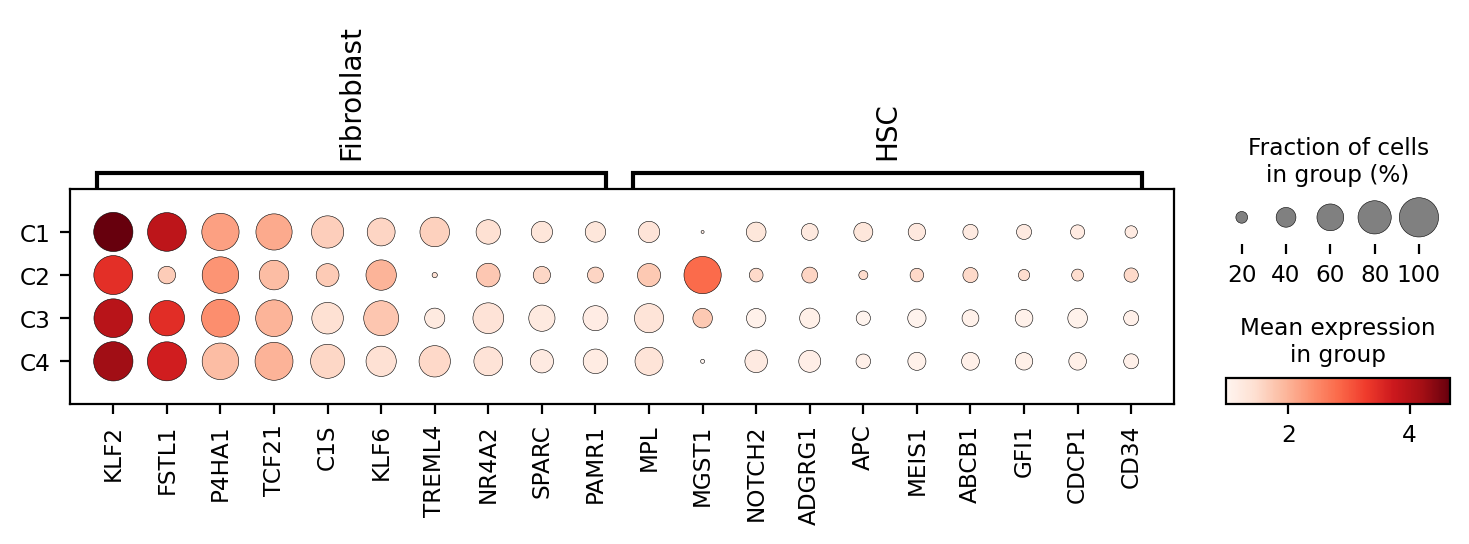

In [66]:
n_top_genes = 10
marker_genes_dict = {
    "Fibroblast" : get_gene_ids(adata, get_top_genes(adata, fb, n_top_genes))['gene_name'].to_list(),
    "HSC" : get_gene_ids(adata, get_top_genes(adata, hp, n_top_genes))['gene_name'].to_list(),
}

plt.rcParams['figure.dpi'] = 200
plt.rcParams['figure.figsize'] = 4, 3
sc.pl.dotplot(adata, 
              marker_genes_dict, 
              'cluster_name', 
              gene_symbols='gene_name',
              mean_only_expressed=True,
              dendrogram=False)


categories: C1, C2, C3, etc.
var_group_labels: Fibroblast, HSC


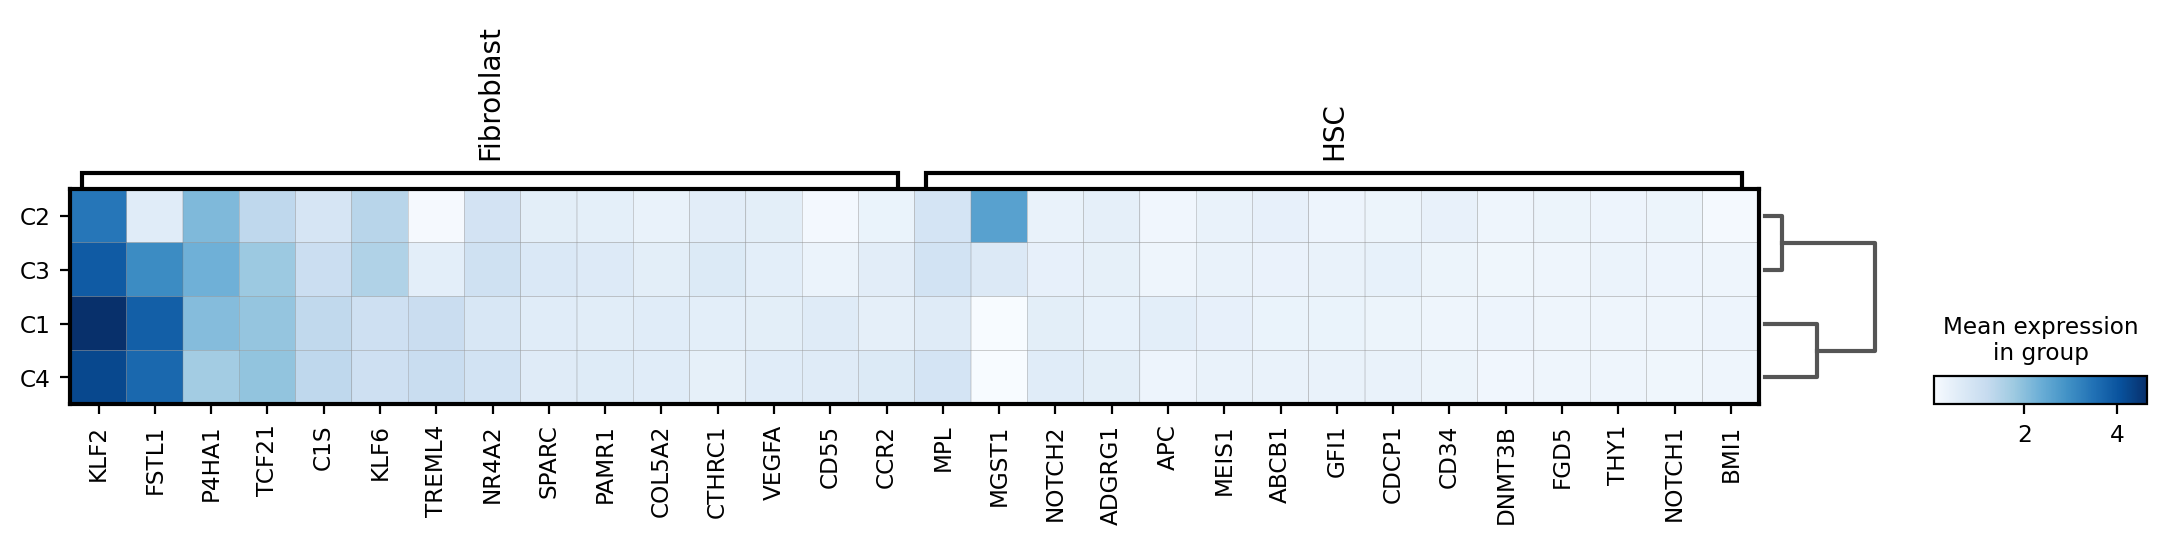

In [76]:
plt.rcParams['figure.dpi'] = 200
plt.rcParams['figure.figsize'] = 4, 4

n_top_genes = 15
marker_genes_dict = {
    "Fibroblast" : get_gene_ids(adata, get_top_genes(adata, fb, n_top_genes))['gene_name'].to_list(),
    "HSC" : get_gene_ids(adata, get_top_genes(adata, hp, n_top_genes))['gene_name'].to_list(),
}

sc.pl.matrixplot(adata, 
                 marker_genes_dict, 
                 groupby='cluster_name', 
                 gene_symbols='gene_name',
                 swap_axes=False, 
                 dendrogram=True,
                 cmap='Blues')

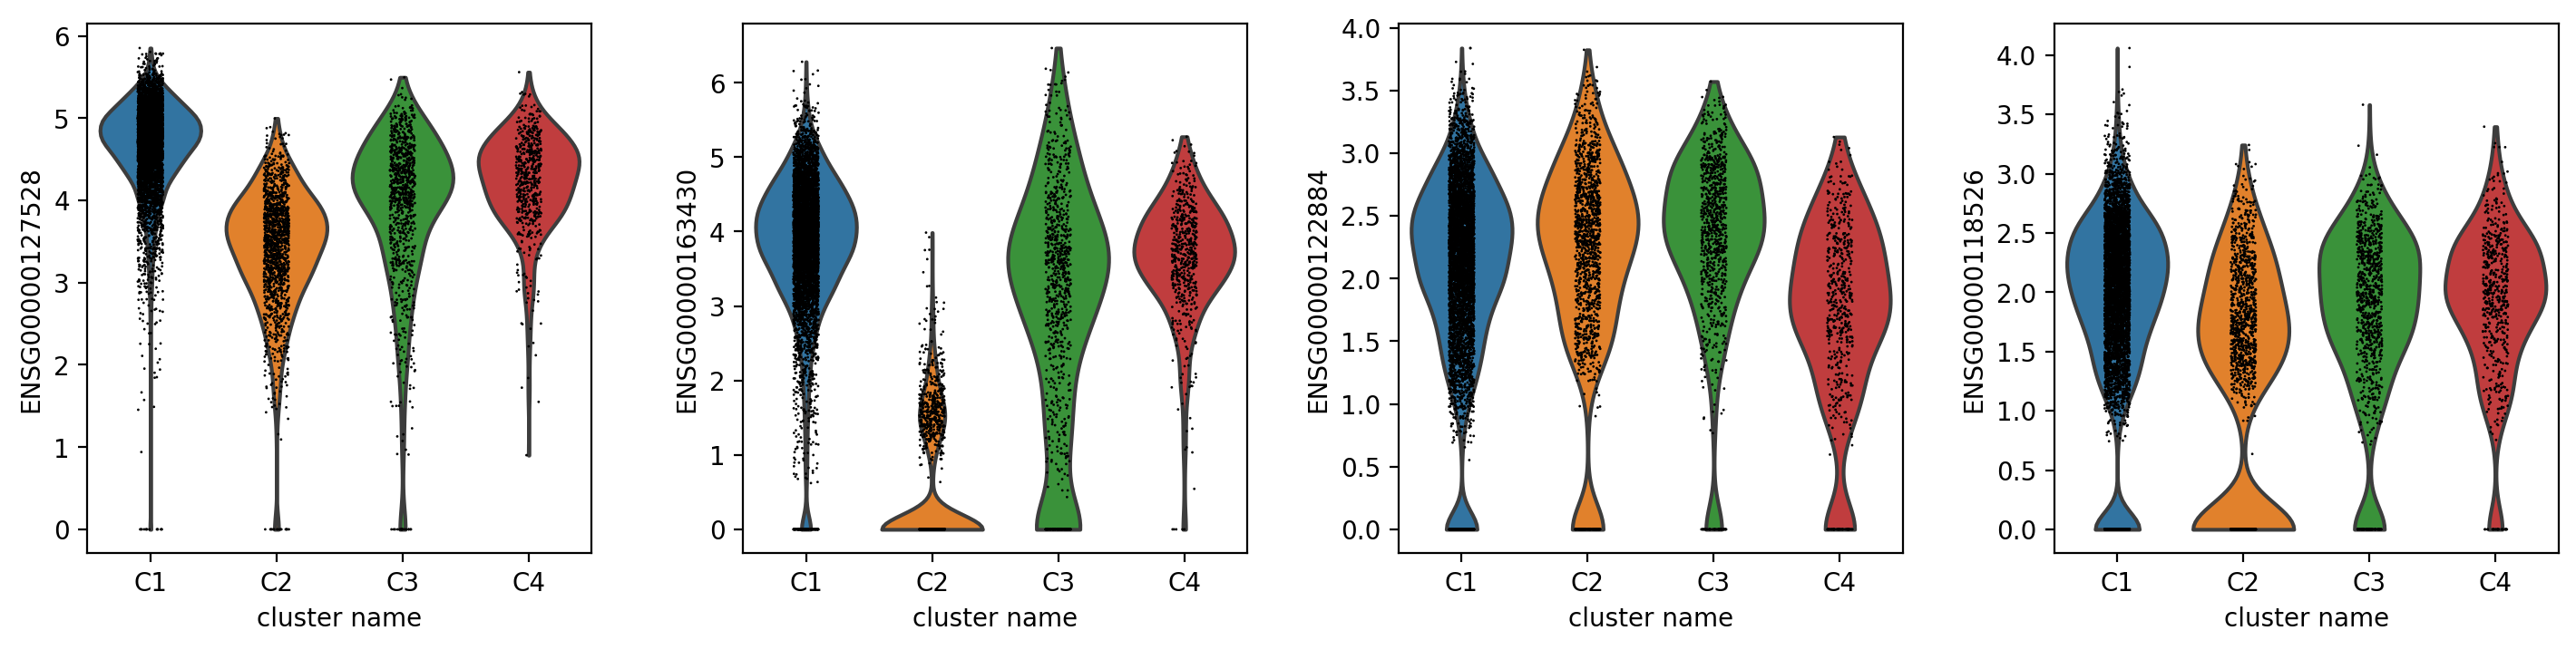

In [69]:
plt.rcParams['figure.dpi'] = 200
plt.rcParams['figure.figsize'] = 4, 4

n_top_genes  = 4
gene_list = get_gene_ids(adata, get_top_genes(adata, fb, n_top_genes))['gene_id'].to_list()

sc.pl.violin(adata, 
             gene_list, 
             gene_symbols='gene_name',
             groupby='cluster_name' )

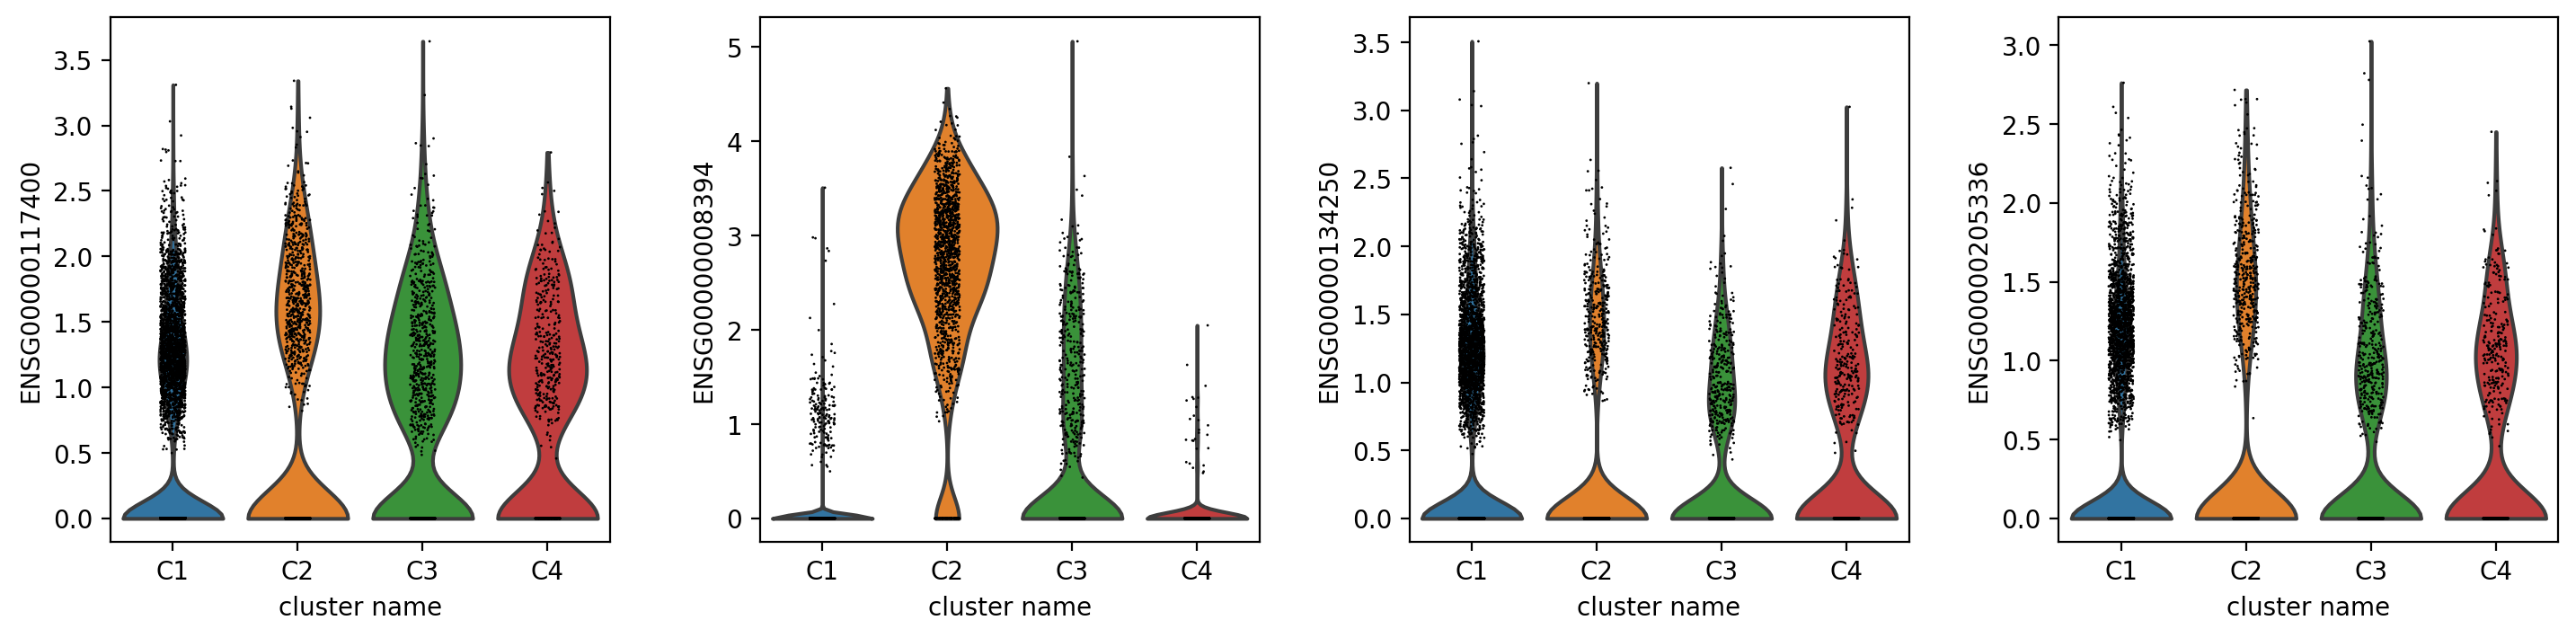

In [70]:
plt.rcParams['figure.dpi'] = 200
plt.rcParams['figure.figsize'] = 4, 4

n_top_genes  = 4
gene_list = get_gene_ids(adata, get_top_genes(adata, hp, n_top_genes))['gene_id'].to_list()

sc.pl.violin(adata, 
             gene_list, 
             gene_symbols='gene_name',
             groupby='cluster_name' )

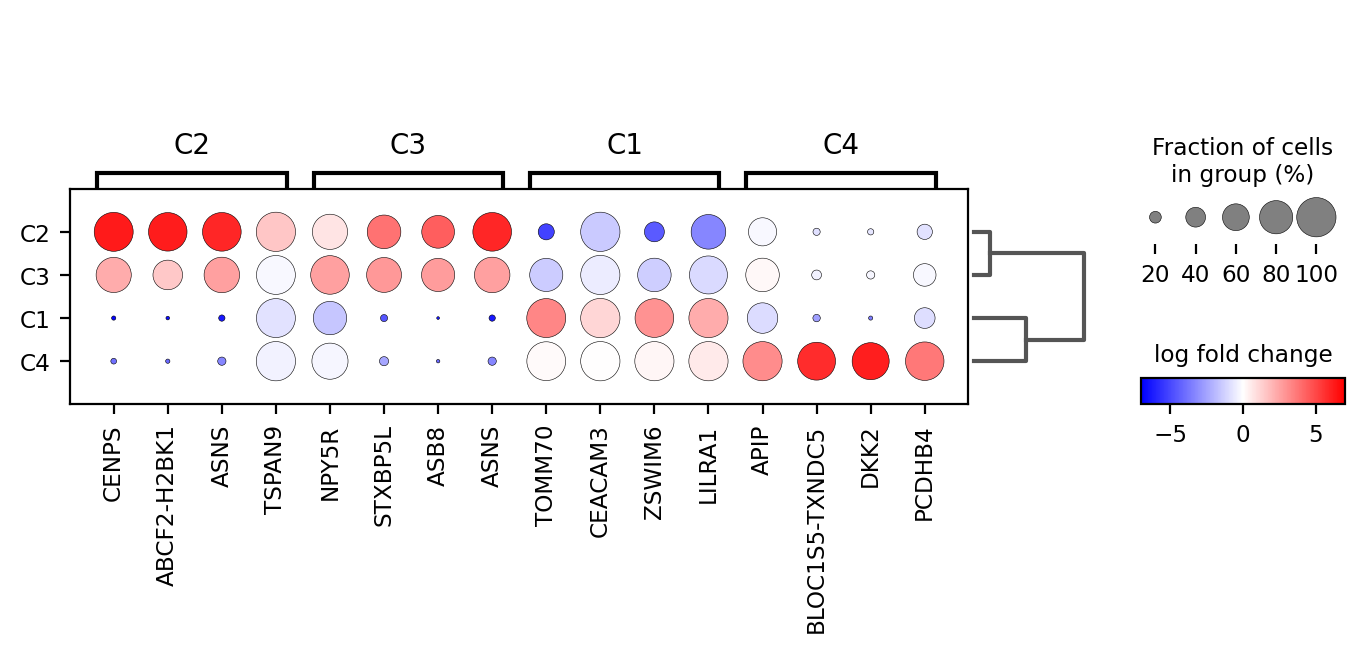

In [80]:
sc.pl.rank_genes_groups_dotplot(adata, 
                                n_genes=4, 
                                values_to_plot='logfoldchanges',
                                min_logfoldchange=1, 
                                gene_symbols='gene_name', 
                                vmax=7, 
                                vmin=-7, 
                                cmap='bwr')

# Highest TF Espression per cluster

In [27]:
# load the human TFs from scenic
tf_path = "/nfs/turbo/umms-indikar/shared/projects/DGC/data/scenic/tf_lists/allTFs_hg38.txt"
tf = pd.read_csv(tf_path, sep='\t', header=None, names=["gene_name"])
print(f"{tf.shape=}")

tf.shape=(1892, 1)


In [28]:
def get_cluster_tfs(deg, tf):
    """A function to get TFs from DEGs """
    df = deg.copy()
    df = df[df['gene_name'].isin(tf['gene_name'].to_list())]
    
    return df

alpha = 0.05
logfoldchange = 1.0
n_genes = 3
cluster_tfs = get_cluster_tfs(deg, tf)
print(f"{cluster_tfs.shape=}")

cluster_tfs['is_significant'] = np.where(cluster_tfs['pvals_adj'] <= alpha, 1, 0)
cluster_tfs['is_upregulated'] = np.where(cluster_tfs['logfoldchanges'] > logfoldchange, 1, 0)
cluster_tfs = cluster_tfs.sort_values(by=['group','is_significant', 'is_upregulated', 'logfoldchanges'], 
                                      ascending=[True, False, False, False])
cluster_tfs.head()

cluster_tfs.shape=(5616, 7)


group            names     scores  logfoldchanges          pvals  \
31     C1  ENSG00000189403  33.592300        2.263279  2.173346e-247   
170    C1  ENSG00000074657  12.817658        2.219431   1.305855e-37   
623    C1  ENSG00000167554   4.613897        2.204566   3.951874e-06   
632    C1  ENSG00000105750   4.565236        1.959032   4.989342e-06   
921    C1  ENSG00000174165   3.237285        1.891954   1.206728e-03   

         pvals_adj gene_name  is_significant  is_upregulated  
31   5.625154e-245     HMGB1               1               1  
170   4.664716e-36    ZNF532               1               1  
623   3.427513e-05    ZNF610               1               1  
632   4.279521e-05     ZNF85               1               1  
921   7.325906e-03   ZDHHC24               1               1

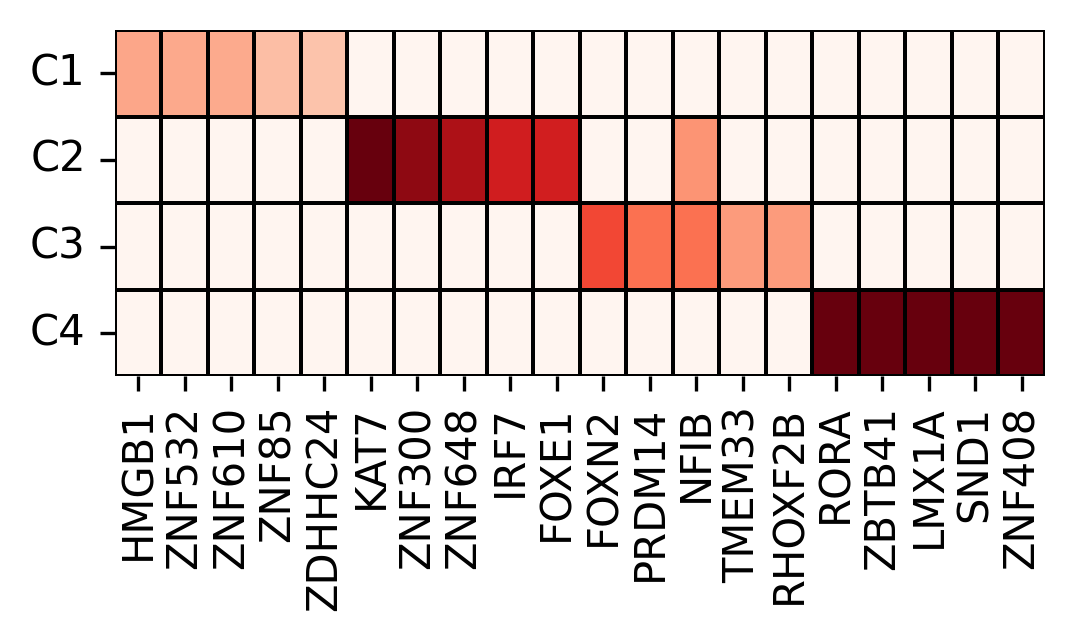

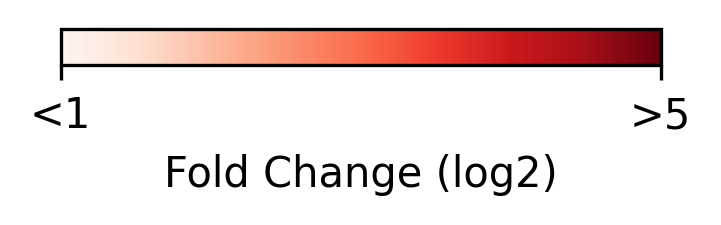

In [29]:
n_genes = 5
vmax = 5
vmin = 1
cmap = 'Reds'

# extract the top TF genes
gx = cluster_tfs.groupby('group').head(n_genes)
gene_order = gx['gene_name'].values
pdf = cluster_tfs[cluster_tfs['gene_name'].isin(gx['gene_name'])]

# structure the table
pdf = pd.pivot_table(pdf, 
                     index='gene_name',
                     columns='group',
                     values='logfoldchanges').T

pdf = pdf[gene_order]

plt.rcParams['figure.dpi'] = 300
plt.rcParams['figure.figsize'] = 4, 1.5
sns.heatmap(pdf, 
            linewidth=0.5, 
            linecolor='k',
            vmin=vmin, 
            vmax=vmax,
            cmap=cmap,
            cbar=False)

plt.xlabel("")
plt.ylabel("")
plt.tick_params(axis='y', rotation=0)

ut.makeColorbar(cmap, 2.5, 0.2, r'Fold Change (log2)', 'horizontal', [f'<{vmin}', f'>{vmax}'])


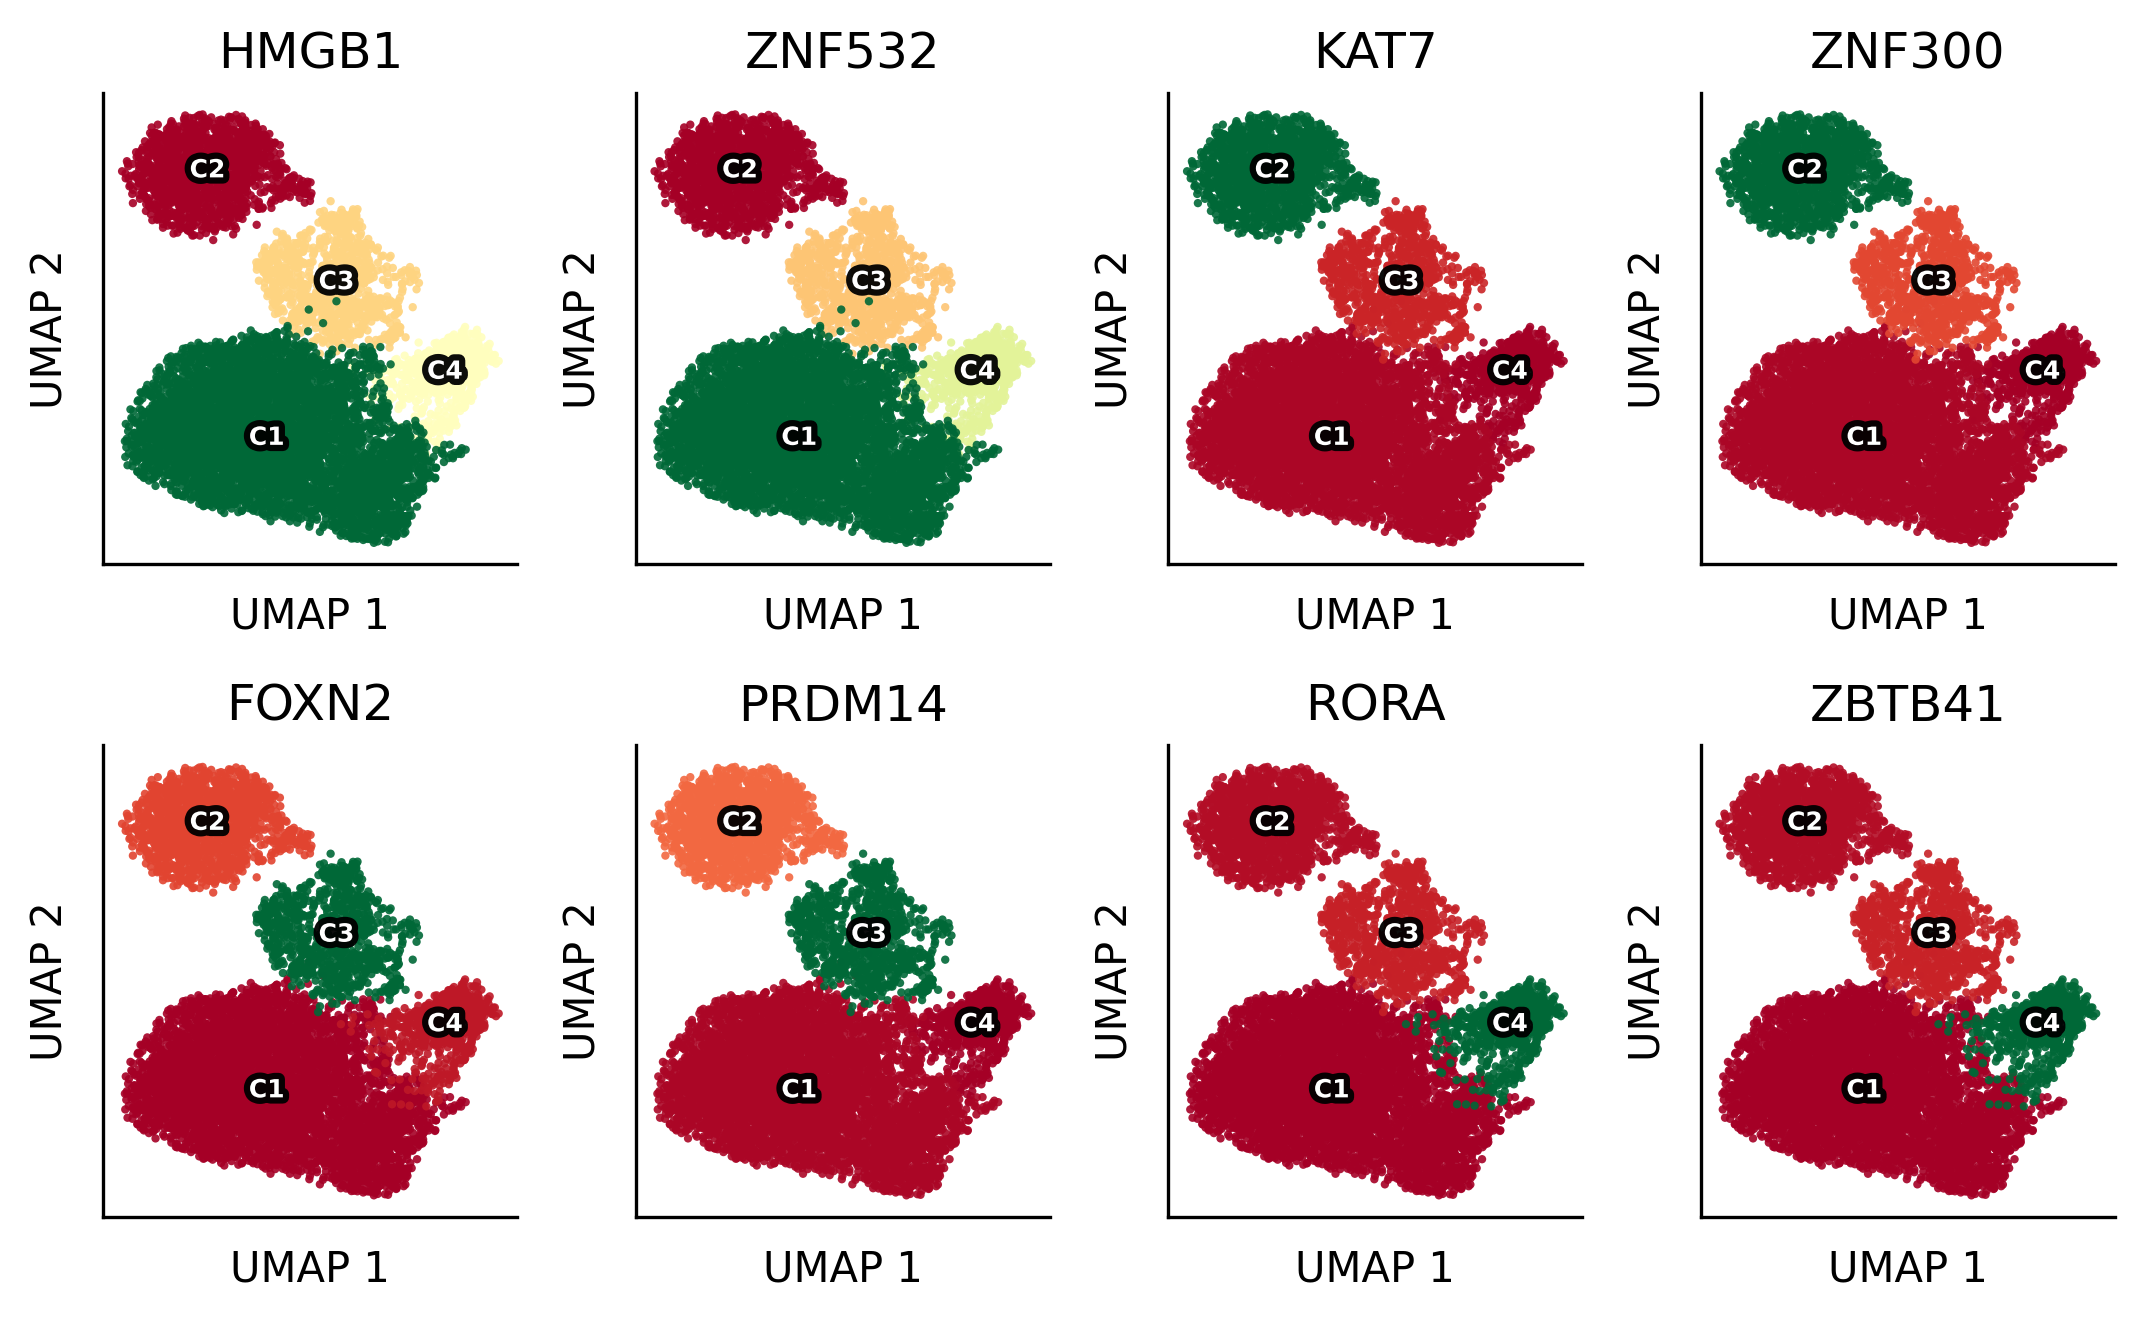

In [30]:
n_genes = 2

# extract the top TF genes
gx = cluster_tfs.groupby('group').head(n_genes)
gene_order = gx['gene_name'].values

plot_cluster_average_expression(adata, 
                                gene_order,
                                all_pos,
                                label_clusters=True,
                                fontsize=6,
                                plot_shape=(2, 4), 
                                fig_shape=(7.25, 4.5))

# Cell type predictions

In [96]:
alpha = 0.1
n_query = 10
lfc_threshold = 1.5

for cluster, group in deg.groupby('group'):
    group = group[group['pvals_adj'] <= alpha]
    group = group[group['logfoldchanges'] > lfc_threshold]
    group = group.sort_values(by='logfoldchanges', ascending=False)
    group = group.head(n_query)

    gene_list = group['gene_name'].to_list()
    edf = gget.enrichr(gene_list, database='celltypes')
    edf['cluster'] = cluster
    print(edf[['cluster', 'path_name', 'adj_p_val']].head())
    print()

Thu Jan 11 15:34:18 2024 INFO Performing Enichr analysis using database PanglaoDB_Augmented_2021. 
    Please note that there might be a more appropriate database for your application. 
    Go to https://maayanlab.cloud/Enrichr/#libraries for a full list of supported databases.
    
Thu Jan 11 15:34:18 2024 INFO Performing Enichr analysis using database PanglaoDB_Augmented_2021. 
    Please note that there might be a more appropriate database for your application. 
    Go to https://maayanlab.cloud/Enrichr/#libraries for a full list of supported databases.
    


  cluster                     path_name  adj_p_val
0      C1    Airway Smooth Muscle Cells   0.011807
1      C1  Vascular Smooth Muscle Cells   0.011807
2      C1               Granulosa Cells   0.011807
3      C1    Adipocyte Progenitor Cells   0.011807
4      C1              His Bundle Cells   0.094489



Thu Jan 11 15:34:18 2024 INFO Performing Enichr analysis using database PanglaoDB_Augmented_2021. 
    Please note that there might be a more appropriate database for your application. 
    Go to https://maayanlab.cloud/Enrichr/#libraries for a full list of supported databases.
    


  cluster                                     path_name  adj_p_val
0      C2  Erythroid-like And Erythroid Precursor Cells   0.087381
1      C2                      Hematopoietic Stem Cells   0.087381
2      C2                                       B Cells   0.087381



Thu Jan 11 15:34:18 2024 INFO Performing Enichr analysis using database PanglaoDB_Augmented_2021. 
    Please note that there might be a more appropriate database for your application. 
    Go to https://maayanlab.cloud/Enrichr/#libraries for a full list of supported databases.
    


  cluster       path_name  adj_p_val
0      C3   Oxyphil Cells   0.103530
1      C3   Spermatocytes   0.103530
2      C3  Cardiomyocytes   0.105639
3      C3      Germ Cells   0.105639

  cluster                  path_name  adj_p_val
0      C4           His Bundle Cells   0.095465
1      C4                 Osteocytes   0.095465
2      C4     Trophoblast Stem Cells   0.095465
3      C4    Kidney Progenitor Cells   0.095465
4      C4  Undefined Placental Cells   0.095465



In [99]:
dpath = "/nfs/turbo/umms-indikar/shared/projects/HSC/data/GO_annotations/"

hdf = []

for f in os.listdir(dpath):
    fpath = f"{dpath}{f}"
    tmp = pd.read_csv(fpath, sep='\t')
    hdf.append(tmp)

hdf = pd.concat(hdf)
print(hdf['GO NAME'].value_counts())
hdf.head()

somatic stem cell population maintenance                               69
stem cell population maintenance                                       60
neuronal stem cell population maintenance                              37
hematopoietic stem cell proliferation                                  32
hematopoietic stem cell homeostasis                                    28
hematopoietic stem cell differentiation                                25
germ-line stem cell population maintenance                              7
mesenchymal stem cell maintenance involved in nephron morphogenesis     3
male germ-line stem cell population maintenance                         2
Name: GO NAME, dtype: int64


GENE PRODUCT DB GENE PRODUCT ID  SYMBOL    QUALIFIER     GO TERM  \
0       UniProtKB      A0A024R9N2   FANCC  involved_in  GO:0097150   
1       UniProtKB      A0A024RAW0   MED21  involved_in  GO:0035019   
2       UniProtKB      A0A0P1J1R0  seTCTP  involved_in  GO:0019827   
3       UniProtKB      A0A0S2Z590    LSM1  involved_in  GO:0019827   
4       UniProtKB      A0A384MR33  SMC1L1  involved_in  GO:0035019   

                                     GO NAME       ECO ID GO EVIDENCE CODE  \
0  neuronal stem cell population maintenance  ECO:0000265              IEA   
1   somatic stem cell population maintenance  ECO:0000265              IEA   
2           stem cell population maintenance  ECO:0000265              IEA   
3           stem cell population maintenance  ECO:0000265              IEA   
4   somatic stem cell population maintenance  ECO:0000265              IEA   

        REFERENCE                                    WITH/FROM  TAXON ID  \
0  GO_REF:0000107  UniProtKB:P50652|ensembl:ENSMUSP00000124406      9606   
1  GO_REF:0000107  UniProtKB:Q9CQ39|ensembl:ENSMUSP00000032429      9606   
2  GO_REF:0000107  UniProtKB:P63028|ensembl:ENSMUSP00000106519      9606   
3  GO_REF:0000107  UniProtKB:Q8VC85|ensembl:ENSMUSP00000041022      9606   
4  GO_REF:0000107  UniProtKB:Q9CU62|ensembl:ENSMUSP00000044645      9606   

  ASSIGNED BY  ANNOTATION EXTENSION GO ASPECT  
0     Ensembl                   NaN         P  
1     Ensembl                   NaN         P  
2     Ensembl                   NaN         P  
3     Ensembl                   NaN         P  
4     Ensembl                   NaN         P

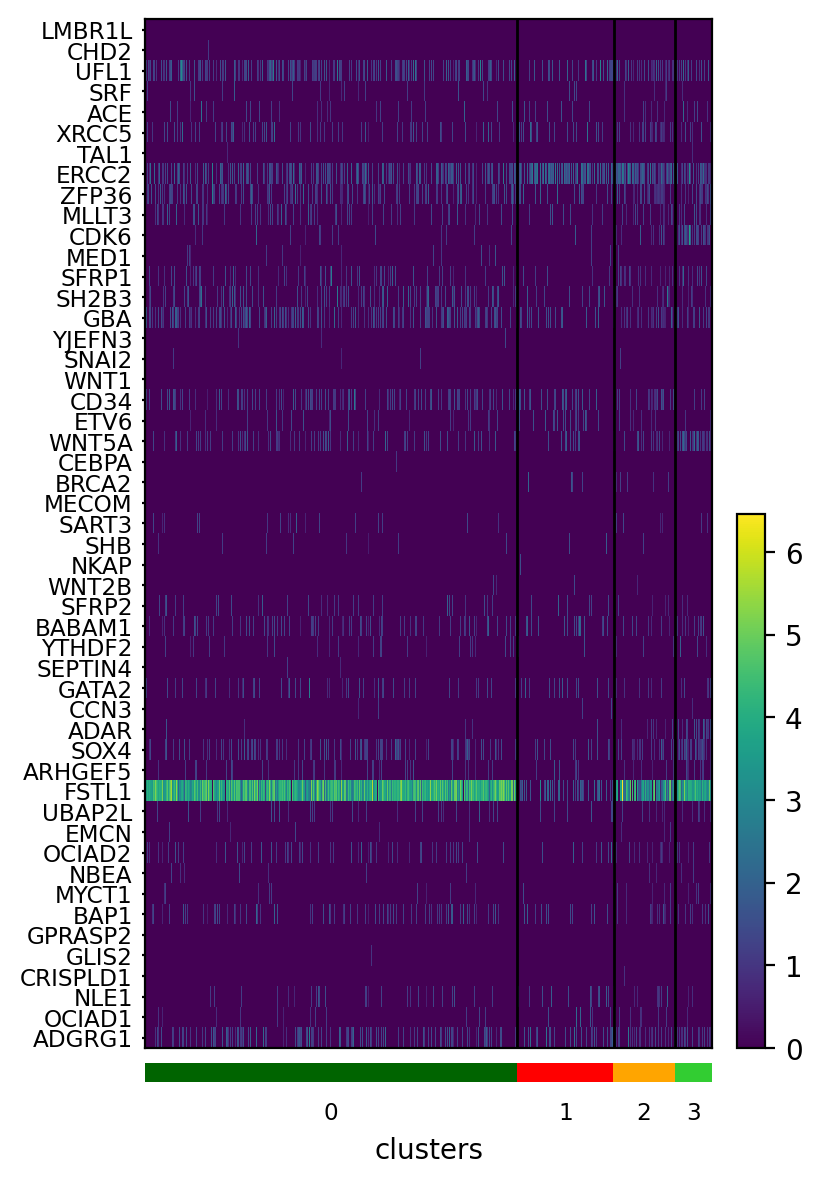

In [102]:
subset = hdf[hdf['GO NAME'].str.contains("hematopoietic")]

var_names = list(subset['SYMBOL'].unique())
var_names = [x for x in var_names if x in adata.var['gene_name'].to_list()]

ax = sc.pl.heatmap(adata,
              groupby='clusters',
              figsize=(4, 7),
              use_raw=False, 
              var_names=var_names,
              swap_axes=True, 
              show=False,
              standard_scale=True,
              show_gene_labels=True,
              gene_symbols='gene_name',
              cmap='viridis')

# Write the Data

In [ ]:
outpath = "/scratch/indikar_root/indikar1/cstansbu/all_HSC/scanpy/anndata_distance.h5ad"
adata.write(outpath)
print('done')

In [ ]:
break

In [ ]:
# hdf.head()

In [ ]:
# # enrichments for each cluster

# alpha = 0.05
# fc_threshold = 0.0
# n_query = 10

# # db = 'ontology'
# # db = 'TRRUST_Transcription_Factors_2019'
# db = 'PanglaoDB_Augmented_2021'

# for cluster, group in deg.groupby('group'):

#     group = group[group['pvals_adj'] < alpha]
#     group = group[group['logfoldchanges'].abs() > fc_threshold]
#     group = group.reset_index(drop=True)

#     group = group.sort_values(by='logfoldchanges', ascending=False)
#     group = group.head(n_query)

#     gene_names = adata.var.loc[group['names'].to_list()]['gene_name'].to_list()
#     print(gene_names)
    
#     # edf = gget.enrichr(gene_names, database=db)
#     # print(edf[['path_name', 'adj_p_val', 'overlapping_genes']].head(10))
    
#     # print()

In [ ]:
# edf = gget.enrichr(gene_names, database=db)

In [ ]:
break

# Pathway analysis

In [ ]:
def parseKEGG(pathId):
    genes = []
    results = REST.kegg_get(pathId).read()
    current_section = None
    for line in results.rstrip().split("\n"):
        section = line[:12].strip()  # section names are within 12 columns
        if not section == "":
            current_section = section

        if current_section == "GENE":
            linesplit = line[12:].split("; ")
            gene_identifiers = linesplit[0]
            gene_id, gene_symbol = gene_identifiers.split()
    
            if not gene_symbol in genes:
                genes.append(gene_symbol)
    return genes

def getPathname(pathId):
    """A function to return the legg pathname"""
    result = REST.kegg_list(pathId).read()
    return result.split("\t")[1].split("-")[0].strip()


pid = "04110"
pgenes = parseKEGG(f"hsa{pid}")
pname = getPathname(f"hsa{pid}")
print(pname)
print(pgenes)

In [ ]:
pids = [
    "04110", 
    "03022", 
    "03020",
    "04310",
    "04330",
    "04115",
    "04218",
    "04810",
    "04710",
    "04713",
]

exp_genes = adata.var['gene_name'].to_list()

pways = {}

for pid in pids:
    pgenes = parseKEGG(f"hsa{pid}")
    pname = getPathname(f"hsa{pid}")
    gene_list = [x for x in pgenes if x in exp_genes]
    print(f"{pname} ({pid}) has {len(pgenes)} genes, {len(gene_list)} expressed")
    pways[pname] = gene_list

print('done')

In [ ]:
for pathway, gene_list in pways.items():
    gene_ids = adata.var[adata.var['gene_name'].isin(gene_list)].index
    adata.obs[f"{pathway}_mean"] = adata[:, gene_ids].X.mean(axis=1)
    adata.obs[f"{pathway}_median"] = np.median(adata[:, gene_ids].X, axis=1)
    adata.obs[f"{pathway}_max"] = adata[:, gene_ids].X.max(axis=1)
    
print('done')

In [ ]:
plt.rcParams['figure.dpi'] = 200
plt.rcParams['figure.figsize'] = 15, 7

pdf = adata.obs.copy()
fig, axs = plt.subplots(2, 5)
axs = axs.ravel()

for i, pathway in enumerate(pways.keys()):
    column_name = f"{pathway}_max"

    # sort order
    order = np.argsort(pdf[column_name])

    sns.scatterplot(data=pdf.iloc[order], 
                    x='UMAP 1',
                    y='UMAP 2',
                    hue=column_name,
                    palette=cmap,
                    alpha=0.9,
                    ax=axs[i],
                    s=5,
                    # hue_norm=(0, 0.2),
                    ec='none')

    axs[i].set_yticks([])
    axs[i].set_xticks([])
    axs[i].legend().remove()
    axs[i].set_title(pathway)

sns.despine()
plt.tight_layout()

# Write data

In [ ]:
outpath = "/nfs/turbo/umms-indikar/shared/projects/HSC/data/single-cell/nov2023_run1/scanpy/anndata_processed.h5ad"
adata.write(outpath)

print('done')

# Some calulcations from flow

In [ ]:
simul = [97.1, 96.3, 97.0]
print(np.mean(simul))
print(np.std(simul))

serial = [84.1, 87.2, 85.2]
print(np.mean(serial))
print(np.std(serial))

both = [84.1, 87.2, 85.2]
print(np.mean(serial))
print(np.std(serial))



In [ ]:

recipe = ['FH3', 'FH3', 'FH6', 'FH6',  'FH7',  'FH7', 'FH8', 'FH8',]
mois = ['Low', 'High'] * 4
CD34 = [1.17, 2.08, 3.33, 1.70, 2.73, 2.09, 3.39, 1.86]

df = pd.DataFrame({
     'Recipe' : recipe,
     'MOI' : mois,
})

df

In [ ]:
gx = df.groupby([''])

In [ ]:

recipe = ['FH3', 'FH3', 'FH6', 'FH6',  'FH7',  'FH7', 'FH8', 'FH8',]
mois = ['Low', 'High'] * 4
CD34 = [1.17, 2.08, 3.33, 1.70, 2.73, 2.09, 3.39, 1.86]

df = pd.DataFrame({
     'Recipe' : recipe,
     'MOI' : mois,
})

df